In [5]:
# importando os pacoteshttp://localhost:8888/notebooks/TCC_0323.ipynb#
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import pandas as pd
print(pd.__version__)

2.1.1


In [6]:
!pip3 install seaborn


^C


In [ ]:
# configuração da exibição
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# importando a base de treino (dados de 2017 até 2022)
df = pd.read_excel('leagues.xlsx')

In [ ]:
df.dtypes

date                   datetime64[ns]
comp                           object
team                           object
opponent                       object
venue                          object
gf                             object
ga                             object
result                         object
Points last season_           float64
dtype: object

In [ ]:
df.comp.unique()

array(['Série A', 'La Liga', 'Premier League', 'Serie A', 'Ligue 1',
       'Bundesliga', 'Primeira Liga', 'Eredivisie', 'A-League',
       'Pro League A'], dtype=object)

In [ ]:
# Convert specific columns from 'object' to 'float'
columns_to_convert = ['gf', 'ga']

# Use pd.to_numeric to convert columns to float
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# 'errors' parameter is set to 'coerce' to handle non-numeric values by converting them to NaN

# Now, the specified columns are of data type 'float'
print(df.dtypes)

date                   datetime64[ns]
comp                           object
team                           object
opponent                       object
venue                          object
gf                            float64
ga                            float64
result                         object
Points last season_           float64
dtype: object


In [ ]:
#df = df[df['date']<= '2022-07-01']

In [ ]:
# inserindo uma coluna com a pontuação obtida em cada partida
df['pont'] = df['result'].replace({'L': 0, 'D': 1, 'W':3})

In [ ]:
df.head()

,date,comp,team,opponent,venue,gf,ga,result,Points last season_,pont
22613,2017-05-13,Série A,Flamengo,Atletico Mineiro,Home,1.0,1.0,D,71.0,1
22615,2017-05-13,Série A,Atletico Mineiro,Flamengo,Away,1.0,1.0,D,62.0,1
22614,2017-05-13,Série A,Chapecoense,Corinthians,Away,1.0,1.0,D,52.0,1
22612,2017-05-13,Série A,Corinthians,Chapecoense,Home,1.0,1.0,D,55.0,1
22607,2017-05-14,Série A,Fluminense,Santos,Home,3.0,2.0,W,50.0,3


In [ ]:
# último resultado do confronto entre os times
# sort the DataFrame by date
df = df.sort_values(by='date')

# group the DataFrame by the home team and away team
grouped = df.groupby(['team', 'opponent'])

In [ ]:
grouped_df = grouped['pont'].apply(lambda x: x.rolling(2, closed='right').sum()).reset_index(drop=True)

In [ ]:
df['last_2_results_sum'] = grouped_df

In [ ]:
df.shape

(38874, 11)

In [ ]:
df.head()

,date,comp,team,opponent,venue,gf,ga,result,Points last season_,pont,last_2_results_sum
0,2017-05-13,Série A,Flamengo,Atletico Mineiro,Home,1.0,1.0,D,71.0,1,NaN
1,2017-05-13,Série A,Atletico Mineiro,Flamengo,Away,1.0,1.0,D,62.0,1,0.0
2,2017-05-13,Série A,Chapecoense,Corinthians,Away,1.0,1.0,D,52.0,1,0.0
3,2017-05-13,Série A,Corinthians,Chapecoense,Home,1.0,1.0,D,55.0,1,3.0
4,2017-05-14,Série A,Gremio,Botafogo RJ,Home,2.0,0.0,W,53.0,3,3.0


In [ ]:
def rolling_sum(group, cols, new_cols, venue):
    group = group.sort_values('date')
    group = group[group['venue'] == venue]
    rolling_stats = group[cols].rolling(3, closed='left').sum()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [ ]:
df_rolling_home = df.groupby('team').apply(lambda x: rolling_sum(x, ['gf', 'ga', 'pont'], ['gf_rolling', 'ga_rolling', 'pont_rolling'], 'Home'))
df_rolling_home = df_rolling_home.droplevel('team')

In [ ]:
df_rolling_away = df.groupby('team').apply(lambda x: rolling_sum(x, ['gf', 'ga', 'pont'], ['gf_rolling', 'ga_rolling', 'pont_rolling'], 'Away'))
df_rolling_away = df_rolling_away.droplevel('team')

In [ ]:
# incluindo variáveis rolling do time jogando fora de casa
df_rolling = df_rolling_home.merge(df_rolling_away, left_on=['date', 'comp', 'opponent'], right_on=['date', 'comp', 'team'], suffixes=('_home','_away'), how='inner')

In [ ]:
df_rolling = df_rolling[['date', 'comp', 'team_home', 'gf_rolling_home', 'ga_rolling_home', 'Points last season__home', 
                         'pont_rolling_home', 'last_2_results_sum_home',
                         'opponent_home', 'gf_rolling_away', 'ga_rolling_away', 'Points last season__away',
                         'pont_rolling_away', 'result_home']]

In [ ]:
df_rolling.rename(columns={"team_home": "home", "opponent_home": "away", "result_home": "result", "last_2_results_sum_home": "last_2_results"}, inplace=True)

In [ ]:
# substituindo valores do denominador do ratio que são 0 por 1, para não dar erro na divisão
df_rolling['pont_rolling_away'].replace(0, 1, inplace=True)
df_rolling['gf_rolling_away'].replace(0, 1, inplace=True)
df_rolling['ga_rolling_away'].replace(0, 1, inplace=True)

In [ ]:
# inserindo coluna com a relação dos indicadores do time1 e time2
df_rolling['gf_rolling_ratio'] = df_rolling['gf_rolling_home']/df_rolling['gf_rolling_away']
df_rolling['ga_rolling_ratio'] = df_rolling['ga_rolling_home']/df_rolling['ga_rolling_away']
df_rolling['points_last_season_ratio'] = df_rolling['Points last season__home']/df_rolling['Points last season__away']
df_rolling['pont_rolling_ratio'] = df_rolling['pont_rolling_home']/df_rolling['pont_rolling_away']

In [ ]:
df_rolling.head()

,date,comp,home,gf_rolling_home,ga_rolling_home,Points last season__home,pont_rolling_home,last_2_results,away,gf_rolling_away,ga_rolling_away,Points last season__away,pont_rolling_away,result,gf_rolling_ratio,ga_rolling_ratio,points_last_season_ratio,pont_rolling_ratio
0,2017-10-15,Eredivisie,ADO Den Haag,3.0,3.0,38.0,4.0,4.0,Excelsior,6.0,3.0,37.0,7.0,L,0.50,1.000000,1.027027,0.571429
1,2017-11-05,Eredivisie,ADO Den Haag,3.0,3.0,38.0,4.0,6.0,Feyenoord,5.0,2.0,82.0,4.0,D,0.60,1.500000,0.463415,1.000000
2,2017-11-19,Eredivisie,ADO Den Haag,4.0,4.0,38.0,4.0,4.0,Heracles Almelo,2.0,7.0,43.0,1.0,W,2.00,0.571429,0.883721,4.000000
3,2017-12-02,Eredivisie,ADO Den Haag,7.0,5.0,38.0,4.0,4.0,Groningen,4.0,7.0,43.0,1.0,L,1.75,0.714286,0.883721,4.000000
4,2017-12-13,Eredivisie,ADO Den Haag,6.0,6.0,38.0,4.0,6.0,Roda JC Kerkrade,1.0,9.0,33.0,1.0,W,6.00,0.666667,1.151515,4.000000


In [ ]:
df_rolling = df_rolling[['date', 'comp', 'home', 'away', 'result', 'last_2_results', 'gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
                        'pont_rolling_ratio']]

In [ ]:
df_rolling.shape

(18362, 10)

In [ ]:
df_rolling = df_rolling[~df_rolling['last_2_results'].isna()]

In [ ]:
df_rolling.shape

(15581, 10)

In [ ]:
# verificando valores missing
df_rolling.isna().sum().sort_values(ascending=False)

date                        0
comp                        0
home                        0
away                        0
result                      0
last_2_results              0
gf_rolling_ratio            0
ga_rolling_ratio            0
points_last_season_ratio    0
pont_rolling_ratio          0
dtype: int64

In [ ]:
# verificando se há linhas duplicadas na base
df_rolling.duplicated().unique()

array([False])

In [ ]:
# criando a coluna 'target' --> Vitóra = 1, Não vitória = 0

conditions = [df_rolling['result'] == 'W', df_rolling['result'] == 'D', df_rolling['result'] == 'L']
    
values = [1, 0, 0]
    
df_rolling['target'] = np.select(conditions, values)

In [ ]:
df_rolling['result'].value_counts()

result
W    6907
L    4796
D    3878
Name: count, dtype: int64

In [ ]:
df_rolling.head()

,date,comp,home,away,result,last_2_results,gf_rolling_ratio,ga_rolling_ratio,points_last_season_ratio,pont_rolling_ratio,target
0,2017-10-15,Eredivisie,ADO Den Haag,Excelsior,L,4.0,0.50,1.000000,1.027027,0.571429,0
1,2017-11-05,Eredivisie,ADO Den Haag,Feyenoord,D,6.0,0.60,1.500000,0.463415,1.000000,0
2,2017-11-19,Eredivisie,ADO Den Haag,Heracles Almelo,W,4.0,2.00,0.571429,0.883721,4.000000,1
3,2017-12-02,Eredivisie,ADO Den Haag,Groningen,L,4.0,1.75,0.714286,0.883721,4.000000,0
4,2017-12-13,Eredivisie,ADO Den Haag,Roda JC Kerkrade,W,6.0,6.00,0.666667,1.151515,4.000000,1


In [ ]:
df_rolling[['last_2_results', 'gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio', 'pont_rolling_ratio', 'target']].corr()['target']

last_2_results              0.000696
gf_rolling_ratio            0.150624
ga_rolling_ratio           -0.122461
points_last_season_ratio    0.292910
pont_rolling_ratio          0.158586
target                      1.000000
Name: target, dtype: float64

### Como o objetivo é predizer qual time tem mais chance de saír vencedor, vamos considerar apenas as partidas onde houve um vencedor. Por esse motivo, vamos excluir os empates da base.

In [ ]:
df_rolling = df_rolling[df_rolling['result'] != 'D']

In [ ]:
# filtrando as colunas que serão utilizadas
df_ml = df_rolling[['date', 'home', 'away', 'gf_rolling_ratio', 'ga_rolling_ratio',
                    'points_last_season_ratio', 
                    'pont_rolling_ratio',
                    'result', 'last_2_results', 'target']]

In [ ]:
df_ml['target'].value_counts()

target
1    6907
0    4796
Name: count, dtype: int64

In [ ]:
df_ml['target'].value_counts(normalize=True)

target
1    0.590191
0    0.409809
Name: proportion, dtype: float64

In [ ]:
df_ml

,date,home,away,gf_rolling_ratio,ga_rolling_ratio,points_last_season_ratio,pont_rolling_ratio,result,last_2_results,target
0,2017-10-15,ADO Den Haag,Excelsior,0.500000,1.000000,1.027027,0.571429,L,4.0,0
2,2017-11-19,ADO Den Haag,Heracles Almelo,2.000000,0.571429,0.883721,4.000000,W,4.0,1
3,2017-12-02,ADO Den Haag,Groningen,1.750000,0.714286,0.883721,4.000000,L,4.0,0
4,2017-12-13,ADO Den Haag,Roda JC Kerkrade,6.000000,0.666667,1.151515,4.000000,W,6.0,1
5,2017-12-22,ADO Den Haag,Zwolle,1.000000,1.500000,1.085714,0.666667,W,4.0,1
...,...,...,...,...,...,...,...,...,...,...
18353,2021-12-18,Zwolle,Twente,0.200000,0.500000,0.926829,0.166667,L,2.0,0
18357,2022-03-13,Zwolle,Feyenoord,0.571429,0.666667,0.644068,0.833333,L,6.0,0
18358,2022-04-03,Zwolle,Go Ahead Eagles,1.000000,0.800000,0.987013,2.000000,L,1.0,0
18359,2022-04-10,Zwolle,AZ Alkmaar,0.222222,1.000000,0.535211,0.142857,W,4.0,1


In [ ]:
# separando a base em treino e teste
from sklearn.model_selection import train_test_split

train_size=0.85

X = df_ml.drop(columns = ['target', 'result', 'date', 'home', 'away']).copy()
y = df_ml['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=train_size, random_state=20)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(9947, 5)
(9947,)
(1756, 5)
(1756,)


(None, None)

In [ ]:
y_train.value_counts(normalize=True)

target
1    0.590429
0    0.409571
Name: proportion, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

target
1    0.588838
0    0.411162
Name: proportion, dtype: float64

# Modelos de Machine Learning

In [ ]:
# Função para trazer as medidas
def medidas(y_test, y_pred_best):
    print(f'precision:{precision_score(y_test, y_pred_best):.2f}')
    print(f'accuracy:{accuracy_score(y_test, y_pred_best):.2f}')
    print(f'recall:{recall_score(y_test, y_pred_best):.2f}')
    print(f'f1_score:{f1_score(y_test, y_pred_best):.2f}')
    print(f'roc_auc_score:{roc_auc_score(y_test, y_pred_best):.2f}')

## Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

In [ ]:
X_train.columns

Index(['gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
       'pont_rolling_ratio', 'last_2_results'],
      dtype='object')

In [ ]:
std_scaller = [('numeric_scaler', SklearnTransformerWrapper(variables=['gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
                                                                       'pont_rolling_ratio',
                                                                       'last_2_results'], transformer=StandardScaler()))]

pipeline = Pipeline(steps= std_scaller + [('logit', LogisticRegression())])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression())])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.6977973568281939

In [ ]:
accuracy_score(y_test, y_pred)

0.6668564920273349

In [ ]:
recall_score(y_test, y_pred)

0.7659574468085106

In [ ]:
f1_score(y_test, y_pred)

0.7302904564315352

In [ ]:
roc_auc_score(y_test, y_pred)

0.6454440973654741

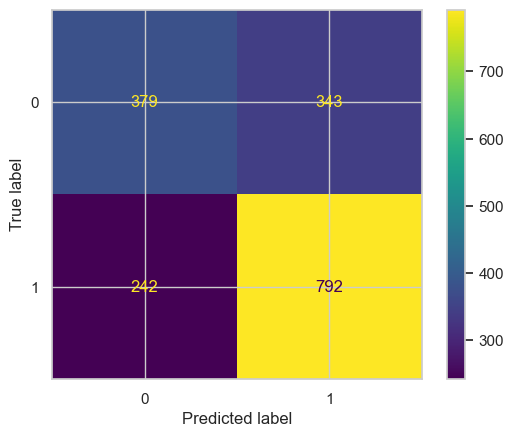

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

In [ ]:
pipeline

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression())])

In [ ]:
pipeline[1].coef_

array([[ 0.17309413, -0.18504879,  0.79811464,  0.051757  ,  0.01384473]])

In [ ]:
pipeline[1].intercept_

array([0.46596276])

In [ ]:
# Grid Search
parametros = {
    'logit__penalty': ['l1', 'l2'],
    'logit__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logit__class_weight': ['balanced', None],
    'logit__fit_intercept': [True, False]
}
grid_search = GridSearchCV(pipeline, parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 48 candidates, totalling 240 fits

{'logit__C': 0.01, 'logit__class_weight': None, 'logit__fit_intercept': True, 'logit__penalty': 'l2'}



In [ ]:
best_lr_pipeline = Pipeline(steps= std_scaller + [('logit', LogisticRegression(C=0.01, class_weight=None, fit_intercept=True, penalty='l2'))])

In [ ]:
best_lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression(C=0.01))])

In [ ]:
y_pred_best = best_lr_pipeline.predict(X_test)

In [ ]:
precision_score_lr = precision_score(y_test, y_pred_best)
accuracy_score_lr = accuracy_score(y_test, y_pred_best)
recall_score_lr = recall_score(y_test, y_pred_best)
f1_score_lr = f1_score(y_test, y_pred_best)
roc_auc_score_lr = roc_auc_score(y_test, y_pred_best)

In [ ]:
precision_score_lr

0.695993031358885

In [ ]:
accuracy_score_lr

0.6674259681093394

In [ ]:
recall_score_lr

0.7727272727272727

In [ ]:
f1_score_lr

0.7323556370302474

In [ ]:
roc_auc_score_lr

0.6446738856711156

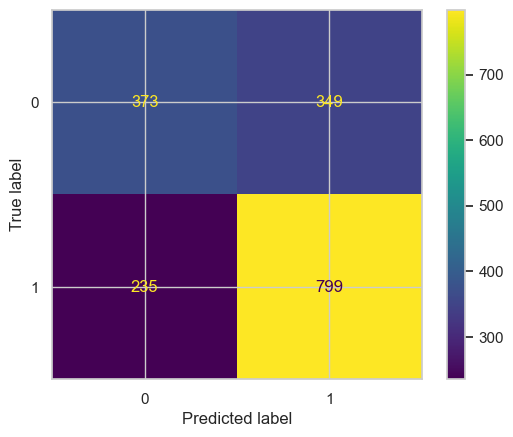

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_lr_pipeline, X_test, y_test, values_format='d')

In [ ]:
best_lr_pipeline[1].coef_

array([[ 0.16560486, -0.17811968,  0.74130275,  0.0664392 ,  0.01288216]])

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
std_scaller = [('numeric_scaler', SklearnTransformerWrapper(variables=['gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
       #'FIFA_23_Overall_ratio',
                                                                       'pont_rolling_ratio', 'last_2_results'], transformer=StandardScaler()))]

pipeline_svc = Pipeline(steps= std_scaller + [('svc', SVC())])

In [ ]:
pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('svc', SVC())])

In [ ]:
y_pred = pipeline_svc.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.679549114331723

In [ ]:
accuracy_score(y_test, y_pred)

0.6651480637813212

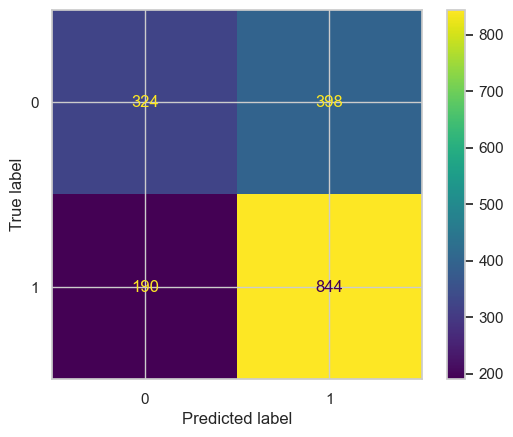

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline_svc, X_test, y_test, values_format='d')

In [ ]:
parametros = {
    'svc__C': [0.01, 0.1, 1, 10], # [0.001, 0.01, 0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'], # ['scale', 'auto'],
    'svc__kernel': ['rbf', 'poly'], # ['rbf', 'poly', 'linear', 'sigmoid'],
    'svc__class_weight': ['balanced', None]
}
grid_search = GridSearchCV(pipeline_svc, parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 32 candidates, totalling 160 fits

{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}



In [ ]:
best_svc_pipeline = Pipeline(steps= std_scaller + [('svc', SVC(C=1, class_weight=None, gamma='scale', kernel='rbf'))])

In [ ]:
best_svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('svc', SVC(C=1))])

In [ ]:
y_pred_best = best_svc_pipeline.predict(X_test)

In [ ]:
precision_score_svm = precision_score(y_test, y_pred_best)
accuracy_score_svm = accuracy_score(y_test, y_pred_best)
recall_score_svm = recall_score(y_test, y_pred_best)
f1_score_svm = f1_score(y_test, y_pred_best)
roc_auc_score_svm = roc_auc_score(y_test, y_pred_best)

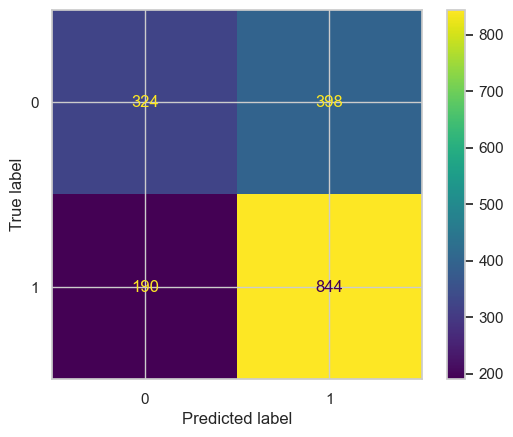

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_svc_pipeline, X_test, y_test, values_format='d')

In [ ]:
accuracy_score_svm

0.6651480637813212

In [ ]:
precision_score_svm

0.679549114331723

In [ ]:
recall_score_svm

0.816247582205029

In [ ]:
f1_score_svm

0.7416520210896309

In [ ]:
roc_auc_score_svm

0.6325005224044535

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = dt.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.6375968992248062

In [ ]:
accuracy_score(y_test, y_pred)

0.5728929384965832

In [ ]:
recall_score(y_test, y_pred)

0.6363636363636364

In [ ]:
f1_score(y_test, y_pred)

0.6369796708615683

In [ ]:
roc_auc_score(y_test, y_pred)

0.5591790480987157

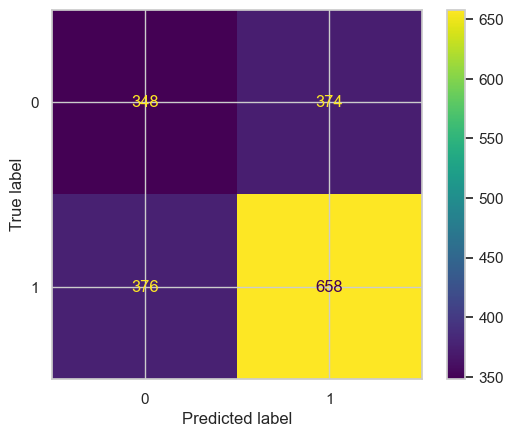

In [ ]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, values_format='d')

In [ ]:
parametros = {
  'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'criterion': ['gini', 'entropy'],
  'class_weight': ['balanced', 'None'],
  'min_samples_split': [2, 3, 4, 5],
}

grid_search = GridSearchCV(DecisionTreeClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 144 candidates, totalling 720 fits

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}



In [ ]:
best_dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4, min_samples_split=2)

In [ ]:
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4)

In [ ]:
y_pred_best = best_dt.predict(X_test)

In [ ]:
precision_score_dt = precision_score(y_test, y_pred_best)
accuracy_score_dt = accuracy_score(y_test, y_pred_best)
recall_score_dt = recall_score(y_test, y_pred_best)
f1_score_dt = f1_score(y_test, y_pred_best)
roc_auc_score_dt = roc_auc_score(y_test, y_pred_best)

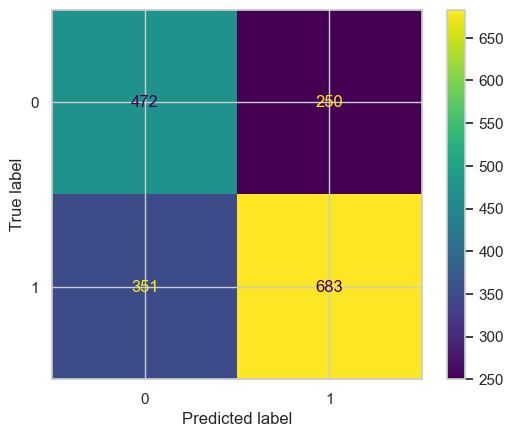

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, values_format='d')

In [ ]:
precision_score_dt

0.7320471596998929

In [ ]:
accuracy_score_dt

0.657744874715262

In [ ]:
recall_score_dt

0.660541586073501

In [ ]:
f1_score_dt

0.6944585663446874

In [ ]:
roc_auc_score_dt

0.6571405991309333

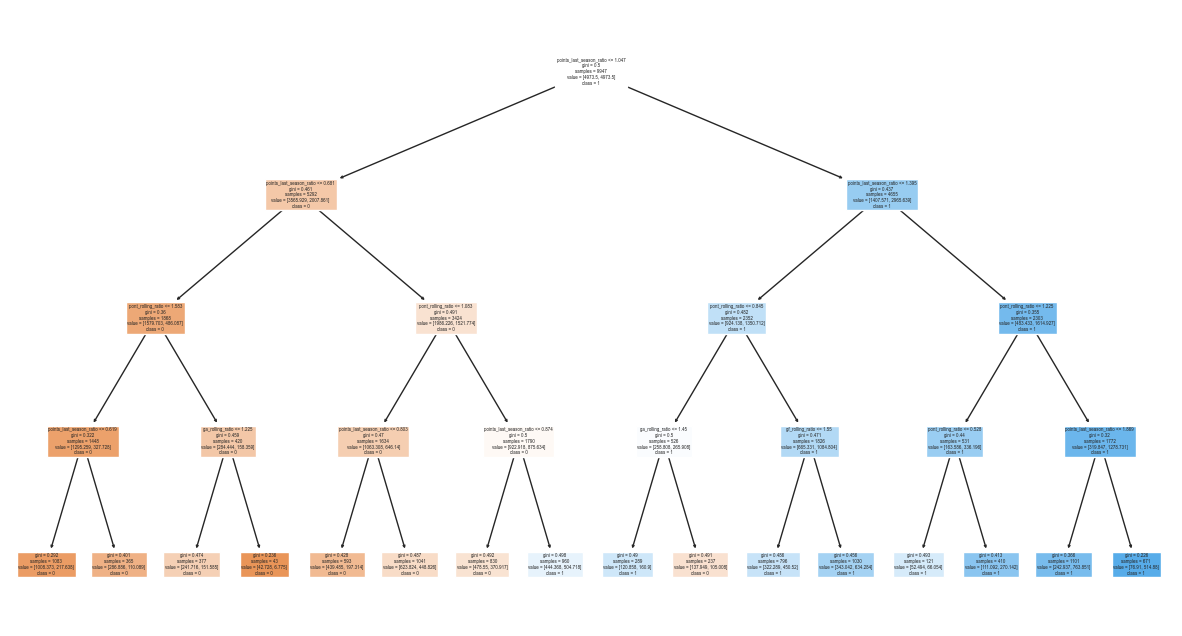

In [ ]:
from sklearn import tree

fig = plt.figure(figsize=(15,8))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.6754068716094033

In [ ]:
accuracy_score(y_test, y_pred)

0.6321184510250569

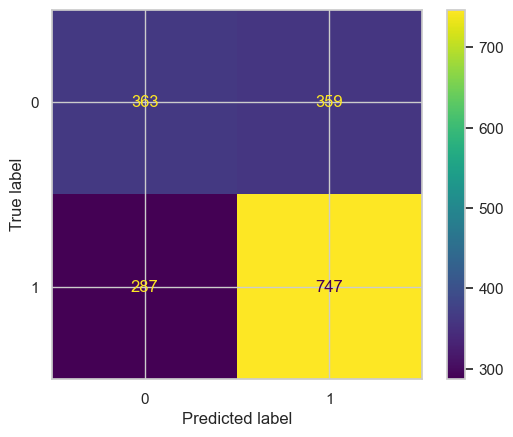

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, values_format='d')

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

parametros = {
    'max_depth': [2, 3, 4, 5, 6, 7], # 25, 30, None],
    'max_features': ['sqrt'], # 'sqrt', 'None'],
    'min_samples_split': [5, 10], # 5, 10, 15, 100],
    'min_samples_leaf': [2, 5], # 5, 10],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 48 candidates, totalling 240 fits

{'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10}



In [ ]:
best_rf = RandomForestClassifier(class_weight= None, max_depth= 3, max_features= 'sqrt',
                                 min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100, random_state=7)

In [ ]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=10,
                       random_state=7)

In [ ]:
y_pred_best = best_rf.predict(X_test)

In [ ]:
    precision_score_rf = precision_score(y_test, y_pred_best)
    accuracy_score_rf = accuracy_score(y_test, y_pred_best)
    recall_score_rf = recall_score(y_test, y_pred_best)
    f1_score_rf = f1_score(y_test, y_pred_best)
    roc_auc_score_rf = roc_auc_score(y_test, y_pred_best)

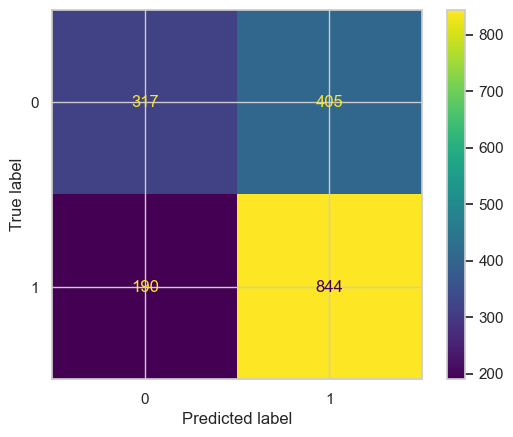

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, values_format='d')

In [ ]:
precision_score_rf

0.6757405924739792

In [ ]:
accuracy_score_rf

0.6611617312072893

In [ ]:
recall_score_rf

0.816247582205029

In [ ]:
f1_score_rf

0.7393780113885239

In [ ]:
roc_auc_score_rf

0.6276528769750908

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
!pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/11/6f/419545a6a344cfd1358a80c36a06431881d607830483ef63d7c38905cd22/xgboost-2.0.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.2/99.7 MB 2.4 MB/s eta 0:00:41
   ---------------------------------------- 0.3/99.7 MB 3.0 MB/s eta 0:00:34
   ---------------------------------------- 0.5/99.7 MB 3.3 MB/s eta 0:00:31
   ---------------------------------------- 0.7/99.7 MB 3.6 MB/s eta 0:00:28
   ---------------------------------------- 0.8/99.7 MB 3.8 MB/s eta 0:00:27
   ---------------------------------------- 0.8/99.7 MB 3.8 MB/s eta 0:00:27
    --------------------------------------- 1.5/99.7 MB 4.2 MB/s eta 0:00:24
    --------------------------------------- 1.7/99.7 MB 4.4 MB/s eta 0:00:23
    ----------------------------


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.6741963509991312

In [ ]:
accuracy_score(y_test, y_pred)

0.6395216400911162

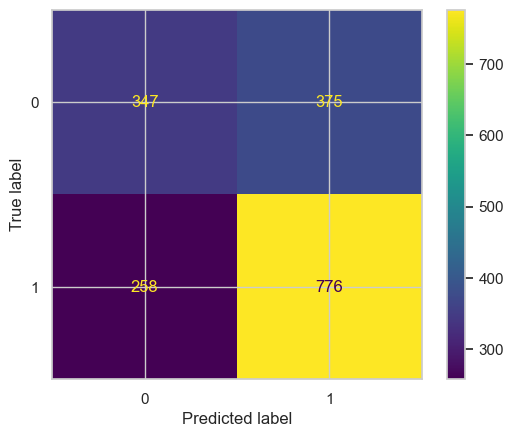

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, values_format='d')

In [ ]:
parametros = {
    'learning_rate': [0.01, 0.1], #[0.1, 0.01, 0.015, 0.025, 0.05, 0.1],
    'n_estimators': [500], # [500, 1000, 2000, 5000, 10000],
    'max_depth': [3, 5, 9], # [3, 5, 7, 9, 12, 15, 17, 25],
    'colsample_bytree': [0.6, 0.8], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.9], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': ['balanced', None],
}

grid_search = GridSearchCV(XGBClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 48 candidates, totalling 240 fits

{'class_weight': 'balanced', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}



In [ ]:
best_xgb = XGBClassifier(class_weight='balanced', colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.9)

In [ ]:
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_best = best_xgb.predict(X_test)

In [ ]:
precision_score_xgb = precision_score(y_test, y_pred_best)
accuracy_score_xgb = accuracy_score(y_test, y_pred_best)
recall_score_xgb = recall_score(y_test, y_pred_best)
f1_score_xgb = f1_score(y_test, y_pred_best)
roc_auc_score_xgb = roc_auc_score(y_test, y_pred_best)

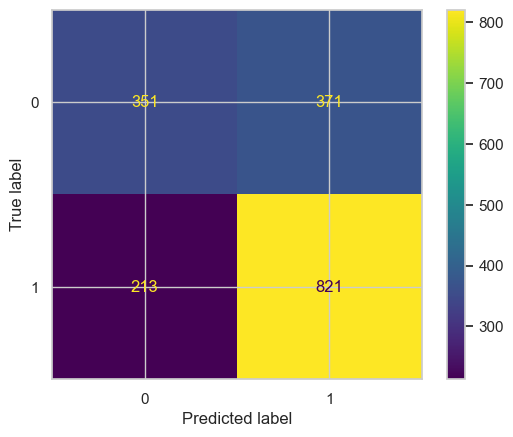

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, values_format='d')

In [ ]:
accuracy_score_xgb

0.6674259681093394

In [ ]:
precision_score_xgb

0.6887583892617449

In [ ]:
recall_score_xgb

0.7940038684719536

In [ ]:
f1_score_xgb

0.7376460017969452

In [ ]:
roc_auc_score_xgb

0.640076726479744

## LGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 960.0 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.3 MB 1.1 MB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.3 MB 2.5 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.3 MB 2.5 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 1.6 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.3 MB 2.1 MB/s eta 0:00:01
   --------------------- ------------------ 0.7/1.3 MB 2.3 MB/s eta 0:00:01
   ---------------------------- ----------- 0.9/1.3 MB 2.7 MB/s eta 0:00:01
   ------------------------------------ --- 1.2/1.3 MB 2.9 MB/s eta 0:00:01
   -----------------------------------


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
lgbm = LGBMClassifier()

In [ ]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5873, number of negative: 4074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 9947, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590429 -> initscore=0.365740
[LightGBM] [Info] Start training from score 0.365740


LGBMClassifier()

In [ ]:
y_pred = lgbm.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

0.6841216216216216

In [ ]:
accuracy_score(y_test, y_pred)

0.6594533029612756

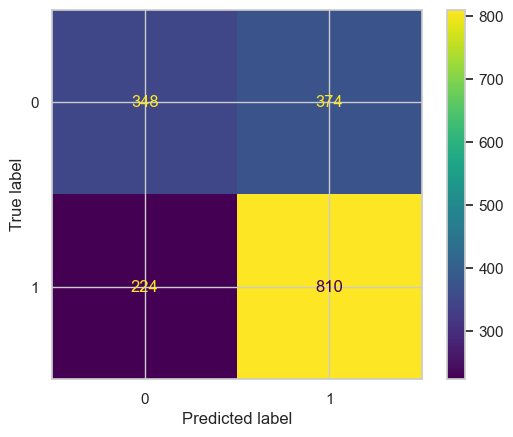

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test, values_format='d')

In [ ]:
parametros = {
    'learning_rate': [0.01, 0.05], # [0.01, 0.015, 0.025, 0.05, 0.1],
    'n_estimators': [500], # [500, 1000, 2000, 5000, 10000],
    'max_depth': [3, 7, 9], # [3, 5, 7, 9, 12, 15, 17, 25],
    'colsample_bytree': [0.6], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.8], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': ['balanced', None],
}

grid_search = GridSearchCV(LGBMClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5873, number of negative: 4074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 9947, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590429 -> initscore=0.365740
[LightGBM] [Info] Start training from score 0.365740

{'class_weight': None, 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.8}



In [ ]:
best_lgbm = LGBMClassifier(class_weight=None, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8)

In [ ]:
best_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5873, number of negative: 4074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 9947, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590429 -> initscore=0.365740
[LightGBM] [Info] Start training from score 0.365740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.01, max_depth=3,
               n_estimators=500, subsample=0.8)

In [ ]:
y_pred_best = best_lgbm.predict(X_test)

In [ ]:
precision_score_lgbm = precision_score(y_test, y_pred_best)
accuracy_score_lgbm = accuracy_score(y_test, y_pred_best)
recall_score_lgbm = recall_score(y_test, y_pred_best)
f1_score_lgbm = f1_score(y_test, y_pred_best)
roc_auc_score_lgbm = roc_auc_score(y_test, y_pred_best)

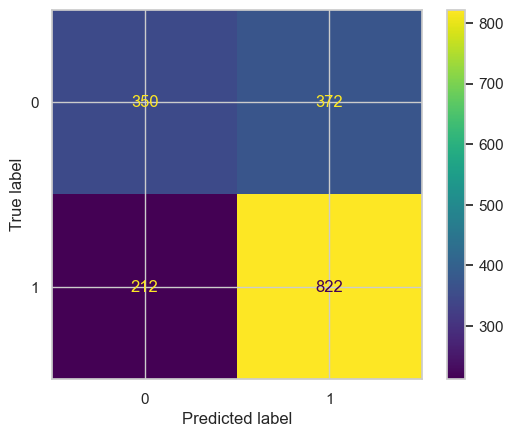

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_lgbm, X_test, y_test, values_format='d')

In [ ]:
accuracy_score_lgbm

0.6674259681093394

In [ ]:
precision_score_lgbm

0.6884422110552764

In [ ]:
recall_score_lgbm

0.7949709864603481

In [ ]:
f1_score_lgbm

0.7378815080789947

In [ ]:
roc_auc_score_lgbm

0.6398677646983182

###  Resumo das métricas de cada modelo


## Melhor modelo:

### Feature importance

In [ ]:
data = {'lr': [precision_score_lr, accuracy_score_lr, recall_score_lr, f1_score_lr, roc_auc_score_lr],
        'svm': [precision_score_svm, accuracy_score_svm, recall_score_svm, f1_score_svm, roc_auc_score_svm],
        'dt': [precision_score_dt, accuracy_score_dt, recall_score_dt, f1_score_dt, roc_auc_score_dt],
        'rf': [precision_score_rf, accuracy_score_rf, recall_score_rf, f1_score_rf, roc_auc_score_rf],
        'xgb': [precision_score_xgb, accuracy_score_xgb, recall_score_xgb, f1_score_xgb, roc_auc_score_xgb],
        'lgbm': [precision_score_lgbm, accuracy_score_lgbm, recall_score_lgbm, f1_score_lgbm, roc_auc_score_lgbm]}

In [ ]:
df_models = pd.DataFrame.from_dict(data, orient='index', columns=['precision', 'accuracy', 'recall', 'f1', 'roc_auc']).round(2)

In [ ]:
df_models

,precision,accuracy,recall,f1,roc_auc
lr,0.70,0.67,0.77,0.73,0.64
svm,0.68,0.67,0.82,0.74,0.63
dt,0.73,0.66,0.66,0.69,0.66
rf,0.68,0.66,0.82,0.74,0.63
xgb,0.69,0.67,0.79,0.74,0.64
lgbm,0.69,0.67,0.79,0.74,0.64


Todos os modelos testados possuem métricas de avaliação muito semelhantes. Como o modelo de **regressão linear** é o mais fácil de ser entendido e explicado, e também possui a maior precisão, esse será o modelo final escolhido.

## Verificando os pesos que o modelo atribuiu para cada variável

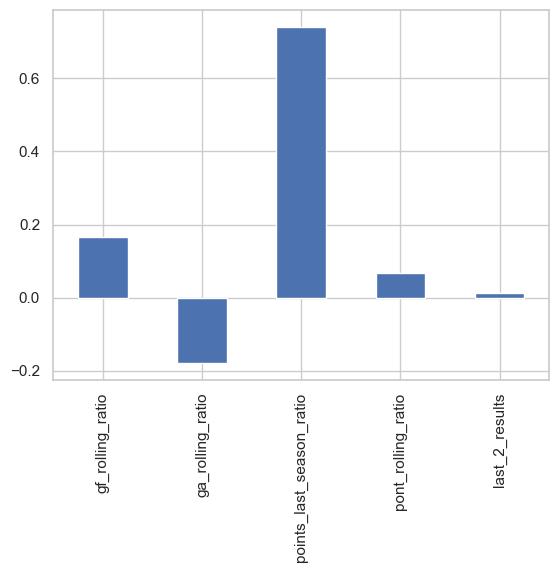

In [ ]:
# Get the coefficients for each feature
coefs = pd.Series(best_lr_pipeline[1].coef_[0], index=X.columns)

# Plot the coefficients
coefs.plot(kind='bar')
plt.show()

In [ ]:
best_lr_pipeline

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression(C=0.01))])

In [ ]:
# salvando o modelo de ML
import joblib

joblib.dump(best_lr_pipeline, "best_lr.pkl")

['best_lr.pkl']

In [ ]:
# imports
import base64
import requests
import pandas as pd
import time
from bs4 import BeautifulSoup
import warnings
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import os
import base64
import joblib

warnings.filterwarnings("ignore")

In [ ]:

service=Service(ChromeDriverManager().install())

# Instanciando o Objeto ChromeOptions
options = webdriver.ChromeOptions()

# Passando algumas opções para esse ChromeOptions
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Criação do WebDriver do Chrome
wd_Chrome = webdriver.Chrome(service=service, options=options)

# Com o WebDrive a gente consegue a pedir a página (URL)
wd_Chrome.get("https://www.flashscore.com/")


In [ ]:
# Fechando Botão de Cookies
try:
    button_cookies = wd_Chrome.find_element(By.CSS_SELECTOR,'button#onetrust-accept-btn-handler')
    button_cookies.click()
except:
    pass

ids = []  # create an empty list to store IDs

time.sleep(5)
for i in range(2):

    # jogos de hoje

    # Pegando o ID dos Jogos
    id_jogos = []
    jogos = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.event__match--scheduled')

    for i in jogos:
        id_jogos.append(i.get_attribute("id"))

    # Exemplo de ID de um jogo: 'g_1_Gb7buXVt'    
    id_jogos = [i[4:] for i in id_jogos]
    
    ids.append(id_jogos)

    # Selecionando o dia de amanhã
    wd_Chrome.find_element(By.CSS_SELECTOR,'button.calendar__navigation--tomorrow').click()
    time.sleep(3)
        
    i=+1

jogo = {'Date':[],'Time':[],'Country':[],'League':[],'Home':[],'Away':[],'Odds_H':[],'Odds_D':[],'Odds_A':[]}    

final_ids = []
for sublist in ids:
    final_ids.extend(sublist)


In [ ]:
final_ids

['vJe1ovS2',
 '8bex28MF',
 'QwMYsmVq',
 'U7dY2l79',
 'QVVqd7km',
 'EwmSwQZI',
 'KhVmeR4g',
 'jsalzxG2',
 'lQfJHuFF',
 'Ovinx7da',
 'zoZ19HMe',
 'zaEzOGyk',
 'rmfNGaUL',
 'txFWOdMr',
 '6LcennXT',
 '8UqNs6uo',
 'dGZh1Pre',
 'WhpwwzcE',
 'Ol86L7Rt',
 '2u7AKRtm',
 'pferGZMr',
 'xxA5pYu9',
 'xz5c3nnl',
 'rBQSzd5U',
 'zXki5RKA',
 'tAjm6754',
 'YP4d2P4T',
 'ENle4ozH',
 'EwwJJQZ3',
 'p4YEK6Kc',
 '48eSd3Sj',
 '6DZALn5i',
 'fZ5h35kN',
 'j5iOcqDp',
 'YgpTsYut',
 'K87LK1vp',
 '2Zypvju5',
 'lrCPJLgj',
 '8CxtuWPb',
 '6ouIHICH',
 '2kQQYRQS',
 '6NWHzldG',
 'M9azElG2',
 'GWGuO7bJ',
 'betQVJHP',
 'jmYiRwQt',
 'K4sMWa2J',
 'UwXeQcum',
 'C2M0PHfg',
 'WCbbrdcb',
 'Ey4gqxrh',
 'zo5kpISo',
 'A3c2sGC4',
 '4Qd6tzSA',
 'jXHOdLVP',
 'rP9jhuvs',
 'CtJKc1GJ',
 '0vJXH3wR',
 'U9VedZQ2',
 'rDsdFFxI',
 'OQFIWG7h',
 'U3GEXdhn',
 'C6OZcLEG',
 '4nAnzfR8',
 'Gvg5rtFT',
 'Qk0horVA',
 'rRWI13Fi',
 '8YHrdaqT',
 'jBMVnVHq',
 '4Ex4Fjfg',
 'MkmaGWvm',
 'f75w0eiP',
 'h2RfyCEO',
 'Uad5eFat',
 'zHo7gOBb',
 'n7ZqbUnO',
 'QcYmcl2U',

In [ ]:
# Pegando as Informacoes Básicas do Jogo
for link in tqdm(final_ids, total=len(final_ids)):
    wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/match-summary')
    
    try:
        Date = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__startTime').text.split(' ')[0]
        Time = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__startTime').text.split(' ')[1]
        Country = wd_Chrome.find_element(By.CSS_SELECTOR,'span.tournamentHeader__country').text.split(':')[0]
        League = wd_Chrome.find_element(By.CSS_SELECTOR,'span.tournamentHeader__country')
        League = League.find_element(By.CSS_SELECTOR,'a').text
        Home = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__home')
        Home = Home.find_element(By.CSS_SELECTOR,'div.participant__participantName').text
        Away = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__away')
        Away = Away.find_element(By.CSS_SELECTOR,'div.participant__participantName').text
    except:
        pass
    time.sleep(2)    
# Match Odds
    try:
        wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/odds-comparison/1x2-odds/full-time')
        time.sleep(2)
        
        linhas = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.ui-table__row')
        
        for linha in linhas:
                
                Odds_H = linha.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[0].text
                Odds_D = linha.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[1].text 
                Odds_A = linha.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[2].text
    except:
        pass

    print(Date,Time,Country,League,Home,Away,Odds_H,Odds_D,Odds_A)


  0%|          | 0/99 [00:04<?, ?it/s]


NameError: name 'Odds_H' is not defined

In [ ]:
jogos = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.event__match--scheduled')

In [ ]:
print(jogos)

[<selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="9B3C710DCDD4EC1FD1C378FD6D648E25_element_52")>]


In [ ]:
wd_Chrome.get(f'https://www.flashscore.com/match/SO9d4oeI/#/odds-comparison/1x2-odds/full-time')

In [ ]:
linhas = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.ui-table__row')

In [ ]:
linhas

[<selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="E11B46E39F205F389DE1B2EF9896ACAD_element_92")>,
 <selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="E11B46E39F205F389DE1B2EF9896ACAD_element_93")>,
 <selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="E11B46E39F205F389DE1B2EF9896ACAD_element_94")>,
 <selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="E11B46E39F205F389DE1B2EF9896ACAD_element_95")>,
 <selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="E11B46E39F205F389DE1B2EF9896ACAD_element_96")>]

In [ ]:
linhas[0]

<selenium.webdriver.remote.webelement.WebElement (session="e6b08ecd295fc7de5fd9e63a55e8d0ef", element="E11B46E39F205F389DE1B2EF9896ACAD_element_92")>

In [ ]:
linhas[0].find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[2].text

'11.00'

In [ ]:
try:
    wd_Chrome.get(f'https://www.flashscore.com/match/SO9d4oeI/#/odds-comparison/1x2-odds/full-time')
    time.sleep(2)
    
    linhas = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.ui-table__row')
    
    for linha in linhas:
            
            Odds_H = linha.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[0].text
            Odds_D = linha.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[1].text 
            Odds_A = linha.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[2].text
except:
    pass

print(Odds_H,Odds_D,Odds_A)

1.25 5.85 12.50


In [ ]:
# imports
import base64
from pickle import TRUE
import requests
import pandas as pd
import requests
import time
from bs4 import BeautifulSoup
import warnings
from git import Repo
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import os
import base64
import joblib
from io import BytesIO
from github import Github
from io import StringIO
import creds

warnings.filterwarnings("ignore")

In [ ]:
# df_rolling
url_df = 'https://github.com/alanhassan/soccerprediction/blob/main/df_rolling.csv?raw=true'
data = requests.get(url_df).content
df_rolling = pd.read_csv(BytesIO(data))

# match_df_final
url_df_l2r = 'https://github.com/alanhassan/soccerprediction/blob/main/match_df_final_all.csv?raw=true'
data_l2r = requests.get(url_df_l2r).content
match_df_final_all = pd.read_csv(BytesIO(data_l2r))

#get ml model from github
url_ml = 'https://github.com/alanhassan/soccerprediction/blob/main/best_lr.pkl?raw=true'

file = BytesIO(requests.get(url_ml).content)

ml = joblib.load(file)

ml.fitted_ = True

In [ ]:
# funções 
# func home
def home(df, team):
    df = df.sort_values(by=['date'])
    df = df[df['home'] == f'{team}'][-1:].drop(columns = ['date', 'comp', 'home', 'away',
                                                            'gf_rolling_away', 'ga_rolling_away',
                                                            'pont_rolling_away', 'Points last season_away'
                                                            ], inplace=False)
    df.rename(columns={"gf_rolling_home": "gf_rolling",
                            "ga_rolling_home": "ga_rolling",
                            "pont_rolling_home": "pont_rolling",
                            "Points last season_home": "Points last season"}, inplace=True)
    df = df[['Points last season', 'pont_rolling', 'gf_rolling', 'ga_rolling']].reset_index(drop=True)
    return df

# func away
def away(df, team):
    df = df.sort_values(by=['date'])
    df = df[df['away'] == f'{team}'][-1:].drop(columns = ['date', 'comp', 'home', 'away',
                                                            'gf_rolling_home', 'ga_rolling_home',
                                                            'pont_rolling_home', 'Points last season_home'
                                                            ], inplace=False)
    df.rename(columns={"gf_rolling_away": "gf_rolling",
                            "ga_rolling_away": "ga_rolling",
                            "pont_rolling_away": "pont_rolling",
                            "Points last season_away": "Points last season"}, inplace=True)
    df = df[['Points last season', 'pont_rolling', 'gf_rolling', 'ga_rolling']].reset_index(drop=True)
    df['pont_rolling'].replace(0, 1, inplace=True)
    df['gf_rolling'].replace(0, 1, inplace=True)
    df['ga_rolling'].replace(0, 1, inplace=True)
    return df

# func ratio
def ratio(df, team1, team2):
    df = home(df, f'{team1}')/away(df, f'{team2}')
    df.rename(columns={"Points last season": "points_last_season_ratio",
                        "pont_rolling": "pont_rolling_ratio",
                        "gf_rolling": "gf_rolling_ratio",
                        "ga_rolling": "ga_rolling_ratio"}, inplace=True)
    return df

# func for 'last_2_results'
def last_2_results(df, team1, team2):
    df = match_df_final_all.sort_values(by='date').reset_index(drop=True)
    length = df[(df['team'] == f'{team1}') & (df['opponent'] == f'{team2}')].shape[0]
    if length >= 2:
        last_2_results_sum = df[(df['team'] == f'{team1}') & (df['opponent'] == f'{team2}')].iloc[-1]['last_2_results_sum']
    elif length == 1:
        last_2_results_sum = df[(df['team'] == f'{team1}') & (df['opponent'] == f'{team2}')].iloc[-1]['pont']
    elif length == 0:
        last_2_results_sum = 1
    return last_2_results_sum


service=Service(ChromeDriverManager().install())

# Instanciando o Objeto ChromeOptions
options = webdriver.ChromeOptions()

# Passando algumas opções para esse ChromeOptions
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Criação do WebDriver do Chrome
wd_Chrome = webdriver.Chrome(service=service, options=options)

# Com o WebDrive a gente consegue a pedir a página (URL)
wd_Chrome.get("https://www.flashscore.com/")

In [ ]:
# Fechando Botão de Cookies
try:
    button_cookies = wd_Chrome.find_element(By.CSS_SELECTOR,'button#onetrust-accept-btn-handler')
    button_cookies.click()
except:
    pass

ids = []  # create an empty list to store IDs

time.sleep(5)
for i in range(3):

    # jogos de hoje

    # Pegando o ID dos Jogos
    id_jogos = []
    jogos = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.event__match--scheduled')

    for i in jogos:
        id_jogos.append(i.get_attribute("id"))

    # Exemplo de ID de um jogo: 'g_1_Gb7buXVt'    
    id_jogos = [i[4:] for i in id_jogos]
    
    ids.append(id_jogos)

    # Selecionando o dia de amanhã
    wd_Chrome.find_element(By.CSS_SELECTOR,'button.calendar__navigation--tomorrow').click()
    time.sleep(3)
        
    i=+1

jogo = {'Date':[],'Time':[],'Country':[],'League':[],'Home':[],'Away':[],'Odds_H':[],'Odds_D':[],'Odds_A':[]}    

final_ids = []
for sublist in ids:
    final_ids.extend(sublist)


# Pegando as Informacoes Básicas do Jogo
for link in tqdm(final_ids, total=len(final_ids)):
    wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/match-summary')
    
    try:
        Date = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__startTime').text.split(' ')[0]
        Time = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__startTime').text.split(' ')[1]
        Country = wd_Chrome.find_element(By.CSS_SELECTOR, 'span.tournamentHeader__country').text.split(':')[0]
        League = wd_Chrome.find_element(By.CSS_SELECTOR, 'span.tournamentHeader__country')
        League = League.find_element(By.CSS_SELECTOR, 'a').text
        Home = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__home')
        Home = Home.find_element(By.CSS_SELECTOR, 'div.participant__participantName').text
        Away = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__away')
        Away = Away.find_element(By.CSS_SELECTOR, 'div.participant__participantName').text
    except:
        continue  # Skip to the next iteration if basic information retrieval fails

    # Match Odds
    try:
        wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/odds-comparison/1x2-odds/full-time')
        time.sleep(2)

        # Check if redirected to match summary page
        if 'match-summary' in wd_Chrome.current_url:
            continue  # Skip to the next iteration if redirected to match summary page

        linhas = wd_Chrome.find_elements(By.CSS_SELECTOR, 'div.ui-table__row')

        for linha in linhas:
            Odds_H = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[0].text
            Odds_D = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[1].text
            Odds_A = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[2].text
    except:
        continue  # Skip to the next iteration if odds information retrieval fails

    print(Date, Time, Country, League, Home, Away, Odds_H, Odds_D, Odds_A)
    
    jogo['Date'].append(Date)
    jogo['Time'].append(Time)
    jogo['Country'].append(Country)
    jogo['League'].append(League)
    jogo['Home'].append(Home)
    jogo['Away'].append(Away)
    jogo['Odds_H'].append(Odds_H)
    jogo['Odds_D'].append(Odds_D)
    jogo['Odds_A'].append(Odds_A)

df = pd.DataFrame(jogo)
df.reset_index(inplace=True, drop=True)
df.index = df.index.set_names(['Nº'])
df = df.rename(index=lambda x: x + 1)

# filtrando o df

df_filtered = df[(df['Country'].str.contains('ENGLAND|GERMANY|SPAIN|ITALY|FRANCE|BRAZIL|PORTUGAL|NETHERLANDS|BELGIUM|AUSTRALIA'))]
df_filtered = df_filtered[(df_filtered['League'].str.contains('PREMIER LEAGUE|BUNDESLIGA|LALIGA|LIGUE 1|SERIE A|LIGA PORTUGAL|EREDIVISIE|JUPILER PRO LEAGUE|A-LEAGUE'))]
df_filtered = df_filtered[~(df_filtered['League'].str.contains('LALIGA2|2. BUNDESLIGA|WOMEN|JUNIOREN|PLAY OFFS|RELEGATION|CUP|LIGA PORTUGAL 2'))]
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'].str.replace('.', '/'), format='%d/%m/%Y').dt.date
df_filtered = df_filtered.sort_values(by=['Date', 'Country'])

  0%|          | 1/215 [00:03<12:55,  3.62s/it]

25.12.2023 13:00 BAHRAIN PREMIER LEAGUE - ROUND 10 Al Riffa Busaiteen 1.28 5.00 8.50


  1%|          | 2/215 [00:07<12:53,  3.63s/it]

25.12.2023 13:00 BAHRAIN PREMIER LEAGUE - ROUND 10 Al-Shabbab Al-Ahli Manama 2.90 3.50 2.15


  1%|▏         | 3/215 [00:10<12:54,  3.65s/it]

25.12.2023 14:00 EGYPT PREMIER LEAGUE - ROUND 10 Baladiyat El Mahalla National Bank Egypt 2.55 3.20 2.65


  2%|▏         | 4/215 [00:14<12:50,  3.65s/it]

25.12.2023 14:00 EGYPT SUPER CUP - SEMI-FINALS Al Ahly Ceramica Cleopatra 1.57 3.75 5.50


  3%|▎         | 7/215 [00:23<11:25,  3.29s/it]

25.12.2023 14:00 ISRAEL LEUMIT LEAGUE - ROUND 14 Ihud Bnei Shfaram Ramat Hasharon 2.35 3.60 2.55


  4%|▎         | 8/215 [00:27<11:35,  3.36s/it]

25.12.2023 14:00 ISRAEL LEUMIT LEAGUE - ROUND 14 Kiryat Shmona M. Herzliya 1.50 3.75 6.00


  4%|▍         | 9/215 [00:30<11:27,  3.34s/it]

25.12.2023 14:00 ISRAEL LEUMIT LEAGUE - ROUND 14 Maccabi Jaffa Bnei Yehuda 2.70 3.50 2.25


  6%|▌         | 12/215 [00:42<12:18,  3.64s/it]

25.12.2023 15:30 ISRAEL STATE CUP - 1/64-FINALS Shikun Vatikim Holon Yermiyahu 25.00 15.00 1.01


  6%|▌         | 13/215 [00:46<12:36,  3.75s/it]

25.12.2023 13:00 IVORY COAST LIGUE 1 - ROUND 14 SOL ASEC Mimosas 6.07 3.71 1.52


  7%|▋         | 14/215 [00:50<13:10,  3.94s/it]

25.12.2023 14:00 KUWAIT PREMIER LEAGUE - ROUND 11 Al Naser Al Salmiya 2.10 3.60 2.90


  7%|▋         | 15/215 [00:54<13:05,  3.93s/it]

25.12.2023 12:15 NIGER LIGUE 1 - ROUND 8 Liberte Akokana 2.01 2.81 4.18


  7%|▋         | 16/215 [00:58<13:06,  3.95s/it]

25.12.2023 12:15 NIGER LIGUE 1 - ROUND 8 Olympic Niamey Urana 2.18 2.95 3.40


  8%|▊         | 17/215 [01:02<13:19,  4.04s/it]

25.12.2023 14:00 TURKEY SUPER LIG - ROUND 18 Hatayspor Besiktas 2.65 3.45 2.52


  8%|▊         | 18/215 [01:06<13:27,  4.10s/it]

25.12.2023 14:00 TURKEY SUPER LIG - ROUND 18 Pendikspor Ankaragucu 2.88 3.35 2.40


  9%|▉         | 19/215 [01:10<13:27,  4.12s/it]

25.12.2023 14:00 TURKEY 1. LIG - ROUND 17 Eyupspor Erzurumspor 1.35 5.00 8.50


  9%|▉         | 20/215 [01:15<13:30,  4.16s/it]

25.12.2023 12:30 WORLD FRIENDLY INTERNATIONAL Kyrgyzstan Uzbekistan 9.50 4.33 1.29


 10%|▉         | 21/215 [01:19<13:37,  4.21s/it]

26.12.2023 09:30 ENGLAND PREMIER LEAGUE - ROUND 19 Newcastle Nottingham 1.50 4.60 6.90


 10%|█         | 22/215 [01:24<13:56,  4.33s/it]

26.12.2023 12:00 ENGLAND PREMIER LEAGUE - ROUND 19 Bournemouth Fulham 2.20 3.70 3.25


 11%|█         | 23/215 [01:28<14:17,  4.47s/it]

26.12.2023 12:00 ENGLAND PREMIER LEAGUE - ROUND 19 Sheffield Utd Luton 2.50 3.40 2.98


 11%|█         | 24/215 [01:33<14:25,  4.53s/it]

26.12.2023 14:30 ENGLAND PREMIER LEAGUE - ROUND 19 Burnley Liverpool 8.20 5.40 1.38


 12%|█▏        | 25/215 [01:38<14:22,  4.54s/it]

26.12.2023 17:00 ENGLAND PREMIER LEAGUE - ROUND 19 Manchester Utd Aston Villa 2.65 3.65 2.65


 13%|█▎        | 29/215 [01:54<12:52,  4.15s/it]

26.12.2023 05:30 BANGLADESH FEDERATION CUP - ROUND 1 Fortis Bashundara Kings 9.50 5.50 1.20


 14%|█▍        | 30/215 [01:58<13:07,  4.26s/it]

26.12.2023 05:30 BANGLADESH FEDERATION CUP - ROUND 1 Rahmatgonj MFS Bangladesh Police 4.75 3.80 1.57


 14%|█▍        | 31/215 [02:03<13:38,  4.45s/it]

26.12.2023 09:30 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Genk Antwerp 2.05 3.75 3.25


 15%|█▍        | 32/215 [02:08<13:41,  4.49s/it]

26.12.2023 12:00 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Kortrijk Gent 8.50 5.00 1.35


 15%|█▌        | 33/215 [02:12<13:45,  4.54s/it]

26.12.2023 12:00 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Leuven Eupen 1.85 4.00 3.75


 16%|█▌        | 34/215 [02:17<13:53,  4.60s/it]

26.12.2023 14:30 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Westerlo RWDM 1.87 3.60 4.00


 16%|█▋        | 35/215 [02:22<13:55,  4.64s/it]

26.12.2023 16:45 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Club Brugge KV Royale Union SG 2.25 3.50 3.00


 17%|█▋        | 36/215 [02:26<13:39,  4.58s/it]

26.12.2023 14:00 EGYPT PREMIER LEAGUE - ROUND 10 Al Ittihad Pharco 2.00 3.20 3.75


 17%|█▋        | 37/215 [02:31<13:34,  4.58s/it]

26.12.2023 09:30 ENGLAND CHAMPIONSHIP - ROUND 24 Preston Leeds 5.45 4.30 1.57


 18%|█▊        | 38/215 [02:36<13:36,  4.61s/it]

26.12.2023 10:00 ENGLAND CHAMPIONSHIP - ROUND 24 Millwall QPR 2.17 3.24 3.53


 18%|█▊        | 39/215 [02:40<13:41,  4.67s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Cardiff Plymouth 1.99 3.72 3.57


 19%|█▊        | 40/215 [02:45<13:47,  4.73s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Coventry Sheffield Wed 1.73 3.69 4.91


 19%|█▉        | 41/215 [02:50<13:44,  4.74s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Huddersfield Blackburn 3.24 3.68 2.12


 20%|█▉        | 42/215 [02:54<13:23,  4.65s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Hull Sunderland 2.43 3.36 2.92


 20%|██        | 43/215 [02:59<13:37,  4.75s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Rotherham Middlesbrough 5.39 4.25 1.58


 20%|██        | 44/215 [03:04<13:22,  4.69s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Southampton Swansea 1.47 4.68 6.38


 21%|██        | 45/215 [03:09<13:22,  4.72s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 Watford Bristol City 1.96 3.46 3.95


 21%|██▏       | 46/215 [03:13<13:08,  4.67s/it]

26.12.2023 12:00 ENGLAND CHAMPIONSHIP - ROUND 24 West Brom Norwich 1.94 3.54 3.93


 22%|██▏       | 47/215 [03:18<12:56,  4.62s/it]

26.12.2023 14:15 ENGLAND CHAMPIONSHIP - ROUND 24 Birmingham Stoke 2.62 3.36 2.67


 22%|██▏       | 48/215 [03:22<12:51,  4.62s/it]

26.12.2023 16:45 ENGLAND CHAMPIONSHIP - ROUND 24 Ipswich Leicester 3.05 3.53 2.27


 23%|██▎       | 49/215 [03:27<12:39,  4.57s/it]

26.12.2023 10:00 ENGLAND LEAGUE ONE - ROUND 24 Leyton Orient Charlton 2.50 3.50 2.65


 23%|██▎       | 50/215 [03:31<12:31,  4.56s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Bristol Rovers Portsmouth 3.25 3.50 2.15


 24%|██▎       | 51/215 [03:36<12:26,  4.55s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Burton Blackpool 4.20 3.75 1.80


 24%|██▍       | 52/215 [03:40<12:23,  4.56s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Cheltenham Shrewsbury 2.15 3.30 3.40


 25%|██▍       | 53/215 [03:45<12:15,  4.54s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Exeter Wycombe 2.85 3.40 2.40


 25%|██▌       | 54/215 [03:49<12:04,  4.50s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Fleetwood Carlisle 2.10 3.50 3.40


 26%|██▌       | 55/215 [03:54<11:58,  4.49s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Lincoln Bolton 3.40 3.40 2.10


 26%|██▌       | 56/215 [03:58<11:54,  4.49s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Oxford Utd Cambridge Utd 1.72 3.75 4.75


 27%|██▋       | 57/215 [04:03<11:39,  4.43s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Peterborough Reading 1.47 4.75 6.00


 27%|██▋       | 58/215 [04:06<10:50,  4.15s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Port Vale Barnsley 2.90 3.50 2.35


 27%|██▋       | 59/215 [04:10<10:17,  3.96s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Stevenage Northampton 1.72 3.75 4.75


 28%|██▊       | 60/215 [04:13<09:55,  3.84s/it]

26.12.2023 12:00 ENGLAND LEAGUE ONE - ROUND 24 Wigan Derby 4.50 3.75 1.75


 28%|██▊       | 61/215 [04:17<09:47,  3.82s/it]

26.12.2023 09:30 ENGLAND LEAGUE TWO - ROUND 24 Mansfield Grimsby 1.50 4.33 6.00


 29%|██▉       | 62/215 [04:21<09:32,  3.74s/it]

26.12.2023 10:00 ENGLAND LEAGUE TWO - ROUND 24 Gillingham Crawley 2.05 3.50 3.50


 29%|██▉       | 63/215 [04:24<09:24,  3.71s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 AFC Wimbledon Sutton 1.50 4.33 6.00


 30%|██▉       | 64/215 [04:28<09:14,  3.67s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Barrow Stockport County 3.25 3.40 2.20


 30%|███       | 65/215 [04:31<08:58,  3.59s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Bradford City Morecambe 1.70 3.75 5.00


 31%|███       | 66/215 [04:35<08:58,  3.62s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Harrogate Accrington 2.85 3.60 2.30


 31%|███       | 67/215 [04:39<09:15,  3.76s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 MK Dons Colchester 1.60 4.20 5.00


 32%|███▏      | 68/215 [04:44<09:50,  4.02s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Newport Forest Green 2.05 3.60 3.40


 32%|███▏      | 69/215 [04:48<10:02,  4.13s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Notts Co Doncaster 1.60 4.20 5.00


 33%|███▎      | 70/215 [04:52<10:13,  4.23s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Salford Tranmere 2.30 3.60 2.90


 33%|███▎      | 71/215 [04:57<10:14,  4.27s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Swindon Wrexham 4.00 4.20 1.75


 33%|███▎      | 72/215 [05:01<10:06,  4.24s/it]

26.12.2023 12:00 ENGLAND LEAGUE TWO - ROUND 24 Walsall Crewe 2.15 3.60 3.20


 34%|███▍      | 73/215 [05:05<09:59,  4.22s/it]

26.12.2023 12:00 GHANA PREMIER LEAGUE - ROUND 16 Medeama Bibiani Gold Stars 1.55 3.60 5.88


 34%|███▍      | 74/215 [05:10<10:10,  4.33s/it]

26.12.2023 11:30 INDIA ISL Punjab Odisha FC 3.20 3.60 2.05


 35%|███▍      | 75/215 [05:14<10:06,  4.33s/it]

26.12.2023 14:00 ISRAEL LIGAT HA'AL - ROUND 12 Netanya SC Ashdod 1.83 3.50 4.00


 35%|███▌      | 76/215 [05:19<10:11,  4.40s/it]

26.12.2023 14:45 ISRAEL LIGAT HA'AL - ROUND 12 Hapoel Jerusalem Hapoel Tel Aviv 2.85 3.00 2.50


 36%|███▌      | 77/215 [05:23<10:15,  4.46s/it]

26.12.2023 15:00 ISRAEL LIGAT HA'AL - ROUND 12 H. Beer Sheva Hapoel Haifa 1.63 4.00 4.75


 39%|███▊      | 83/215 [05:46<08:46,  3.99s/it]

26.12.2023 14:00 ISRAEL STATE CUP - 1/64-FINALS Nahariya Maccabi Nujeidat Ahmad 3.80 3.25 1.90


 40%|████      | 87/215 [06:02<08:38,  4.05s/it]

26.12.2023 08:30 ITALY SERIE B - ROUND 19 Reggiana Catanzaro 2.80 3.00 2.65


 41%|████      | 88/215 [06:07<08:53,  4.20s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 Ascoli Cittadella 2.75 3.00 2.70


 41%|████▏     | 89/215 [06:11<08:57,  4.27s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 Brescia Parma 3.30 3.20 2.20


 42%|████▏     | 90/215 [06:16<09:00,  4.32s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 Cosenza Como 2.65 3.20 2.65


 42%|████▏     | 91/215 [06:20<09:02,  4.38s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 FeralpiSalo Venezia 3.75 3.40 1.95


 43%|████▎     | 92/215 [06:25<08:59,  4.39s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 Lecco Sudtirol 2.45 3.10 2.95


 43%|████▎     | 93/215 [06:29<08:53,  4.37s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 Spezia Modena 2.30 3.20 3.10


 44%|████▎     | 94/215 [06:33<08:41,  4.31s/it]

26.12.2023 11:00 ITALY SERIE B - ROUND 19 Ternana Pisa 2.45 3.30 2.80


 44%|████▍     | 95/215 [06:37<08:18,  4.16s/it]

26.12.2023 14:00 ITALY SERIE B - ROUND 19 Palermo Cremonese 2.50 3.30 2.70


 45%|████▍     | 96/215 [06:41<07:54,  3.99s/it]

26.12.2023 16:30 ITALY SERIE B - ROUND 19 Sampdoria Bari 2.10 3.20 3.60


 45%|████▌     | 97/215 [06:44<07:32,  3.83s/it]

26.12.2023 12:45 MALI PREMIERE DIVISION - ROUND 11 AS Police Binga 2.35 2.81 3.21


 46%|████▌     | 99/215 [06:51<07:13,  3.73s/it]

26.12.2023 12:45 MALI PREMIERE DIVISION - ROUND 11 Djoliba Korofina 1.90 3.05 4.21


 47%|████▋     | 100/215 [06:55<07:16,  3.80s/it]

26.12.2023 12:45 MALI PREMIERE DIVISION - ROUND 11 Real Bamako Bougouba 1.76 3.28 4.56


 47%|████▋     | 101/215 [06:59<07:24,  3.90s/it]

26.12.2023 12:45 MALI PREMIERE DIVISION - ROUND 11 Stade Malien Black Stars 1.65 3.42 5.15


 47%|████▋     | 102/215 [07:04<07:38,  4.06s/it]

26.12.2023 14:00 MOROCCO BOTOLA PRO - ROUND 11 Hassania Agadir Wydad 5.00 3.75 1.62


 48%|████▊     | 103/215 [07:08<07:41,  4.12s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL PREMIERSHIP - ROUND 23 Ballymena Coleraine 4.20 3.75 1.75


 48%|████▊     | 104/215 [07:12<07:42,  4.16s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL PREMIERSHIP - ROUND 23 Carrick Rangers Larne 7.50 4.50 1.38


 49%|████▉     | 105/215 [07:17<07:45,  4.24s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL PREMIERSHIP - ROUND 23 Cliftonville Crusaders 1.80 3.60 4.00


 49%|████▉     | 106/215 [07:21<07:40,  4.23s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL PREMIERSHIP - ROUND 23 Linfield Glentoran 1.70 4.00 4.20


 50%|████▉     | 107/215 [07:25<07:36,  4.23s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL PREMIERSHIP - ROUND 23 Loughgall Dungannon 3.10 3.75 2.05


 50%|█████     | 108/215 [07:29<07:34,  4.25s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL PREMIERSHIP - ROUND 23 Newry City Glenavon 3.50 3.75 1.90


 51%|█████     | 109/215 [07:33<07:26,  4.21s/it]

26.12.2023 11:00 NORTHERN IRELAND NIFL CHAMPIONSHIP - ROUND 22 Knockbreda Institute 6.15 4.65 1.40


 51%|█████     | 110/215 [07:37<07:15,  4.14s/it]

26.12.2023 11:00 NORTHERN IRELAND NIFL CHAMPIONSHIP - ROUND 22 Newington Ballyclare 2.35 3.66 2.48


 52%|█████▏    | 111/215 [07:42<07:13,  4.17s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL CHAMPIONSHIP - ROUND 22 Annagh Portadown 3.72 3.86 1.77


 52%|█████▏    | 112/215 [07:46<07:10,  4.18s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL CHAMPIONSHIP - ROUND 22 Ards Bangor FC 2.60 3.70 2.24


 53%|█████▎    | 113/215 [07:50<07:01,  4.13s/it]

26.12.2023 12:00 NORTHERN IRELAND NIFL CHAMPIONSHIP - ROUND 22 Dergview Ballinamallard 2.44 3.54 2.44


 53%|█████▎    | 114/215 [07:54<07:09,  4.25s/it]

26.12.2023 15:00 SAUDI ARABIA SAUDI PROFESSIONAL LEAGUE - ROUND 17 Al Ittihad Al Nassr 4.50 4.33 1.63


 53%|█████▎    | 115/215 [07:59<07:02,  4.22s/it]

26.12.2023 09:00 SAUDI ARABIA DIVISION 1 - ROUND 15 Al Adalah Al Ain 1.72 3.50 4.33


 54%|█████▍    | 116/215 [08:02<06:47,  4.12s/it]

26.12.2023 09:30 SAUDI ARABIA DIVISION 1 - ROUND 15 Al Jabalain Al Safa 1.60 3.60 5.00


 54%|█████▍    | 117/215 [08:06<06:19,  3.88s/it]

26.12.2023 12:00 SCOTLAND PREMIERSHIP - ROUND 20 Dundee FC Celtic 10.00 5.50 1.28


 55%|█████▌    | 119/215 [08:13<05:51,  3.66s/it]

26.12.2023 10:00 TUNISIA LIGUE PROFESSIONNELLE 1 - ROUND 12 Olympique Beja Ben Guerdane 2.40 2.80 3.10


 56%|█████▌    | 120/215 [08:17<06:06,  3.85s/it]

26.12.2023 10:00 TUNISIA LIGUE PROFESSIONNELLE 1 - ROUND 12 Soliman Gafsa 2.35 2.75 3.20


 56%|█████▋    | 121/215 [08:21<06:09,  3.93s/it]

26.12.2023 10:00 TUNISIA LIGUE PROFESSIONNELLE 1 - ROUND 12 Stade Tunisien Club Africain 2.25 2.90 3.25


 57%|█████▋    | 122/215 [08:25<06:10,  3.98s/it]

26.12.2023 08:00 VIETNAM V.LEAGUE 1 - ROUND 8 Khanh Hoa Song Lam Nghe An 2.60 3.20 2.50


 57%|█████▋    | 123/215 [08:29<06:09,  4.01s/it]

26.12.2023 09:15 VIETNAM V.LEAGUE 1 - ROUND 8 Cong An Binh Duong 1.80 3.40 4.00


 58%|█████▊    | 124/215 [08:33<06:11,  4.08s/it]

26.12.2023 09:15 VIETNAM V.LEAGUE 1 - ROUND 8 Ho Chi Minh Hong Linh Ha Tinh 1.87 3.40 3.75


 58%|█████▊    | 125/215 [08:37<06:08,  4.09s/it]

26.12.2023 11:30 WALES CYMRU PREMIER - ROUND 20 Cardiff Metropolitan Penybont 2.50 3.50 2.55


 59%|█████▊    | 126/215 [08:42<06:08,  4.15s/it]

26.12.2023 11:30 WALES CYMRU PREMIER - ROUND 20 Colwyn Bay Bala 3.50 3.60 1.95


 59%|█████▉    | 127/215 [08:46<06:07,  4.18s/it]

26.12.2023 11:30 WALES CYMRU PREMIER - ROUND 20 Haverfordwest Barry 1.95 3.60 3.40


 60%|█████▉    | 128/215 [08:50<05:51,  4.04s/it]

26.12.2023 11:30 WALES CYMRU PREMIER - ROUND 20 Newtown Connahs Q. 3.50 3.60 1.95


 60%|██████    | 129/215 [08:53<05:34,  3.89s/it]

26.12.2023 11:30 WALES CYMRU PREMIER - ROUND 20 Pontypridd Aberystwyth 1.90 3.75 3.50


 60%|██████    | 130/215 [08:57<05:18,  3.74s/it]

26.12.2023 11:30 WALES CYMRU PREMIER - ROUND 20 TNS Caernarfon 1.11 8.50 17.00


 63%|██████▎   | 136/215 [09:19<05:03,  3.84s/it]

26.12.2023 14:30 WALES CYMRU SOUTH - ROUND 17 Trefelin Afan Lido 4.00 4.33 1.62


 67%|██████▋   | 144/215 [09:49<04:32,  3.84s/it]

26.12.2023 03:00 WORLD FRIENDLY INTERNATIONAL China U23 Malaysia U23 1.58 4.00 5.40


 68%|██████▊   | 147/215 [10:01<04:34,  4.03s/it]

27.12.2023 16:30 ENGLAND PREMIER LEAGUE - ROUND 19 Brentford Wolves 2.00 3.65 3.85


 69%|██████▉   | 148/215 [10:06<04:42,  4.21s/it]

27.12.2023 16:30 ENGLAND PREMIER LEAGUE - ROUND 19 Chelsea Crystal Palace 1.78 3.90 4.65


 69%|██████▉   | 149/215 [10:11<04:48,  4.37s/it]

27.12.2023 17:15 ENGLAND PREMIER LEAGUE - ROUND 19 Everton Manchester City 5.90 4.30 1.58


 70%|███████   | 151/215 [10:19<04:36,  4.33s/it]

27.12.2023 14:30 BELGIUM JUPILER PRO LEAGUE - ROUND 20 St. Liege St. Truiden 2.35 3.40 2.95


 71%|███████   | 152/215 [10:23<04:34,  4.36s/it]

27.12.2023 16:45 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Anderlecht Cercle Brugge KSV 1.87 3.75 3.75


 71%|███████   | 153/215 [10:28<04:34,  4.43s/it]

27.12.2023 16:45 BELGIUM JUPILER PRO LEAGUE - ROUND 20 Charleroi KV Mechelen 2.10 3.40 3.40


 73%|███████▎  | 157/215 [10:44<04:03,  4.20s/it]

27.12.2023 14:00 EGYPT PREMIER LEAGUE - ROUND 10 Smouha El Gaish 2.55 2.95 2.85


 73%|███████▎  | 158/215 [10:48<03:59,  4.21s/it]

27.12.2023 11:30 INDIA ISL Mohun Bagan Kerala Blasters 1.91 3.75 3.80


 74%|███████▍  | 159/215 [10:53<03:54,  4.18s/it]

27.12.2023 11:00 IRAQ SUPER LEAGUE - ROUND 5 Al Zawraa Al Wasat 1.42 3.82 7.95


 74%|███████▍  | 160/215 [10:57<03:50,  4.19s/it]

27.12.2023 11:00 IRAQ SUPER LEAGUE - ROUND 6 Zakho Al-Qassim 2.38 2.85 3.36


 75%|███████▌  | 162/215 [11:19<06:19,  7.16s/it]

27.12.2023 14:00 ISRAEL LIGAT HA'AL - ROUND 12 Sakhnin Hapoel Hadera 2.10 3.20 3.40


 76%|███████▌  | 163/215 [11:24<05:27,  6.31s/it]

27.12.2023 14:45 ISRAEL LIGAT HA'AL - ROUND 12 Maccabi Petah Tikva Hapoel Petah Tikva 2.10 3.25 3.40


 76%|███████▋  | 164/215 [11:28<04:52,  5.73s/it]

27.12.2023 15:00 ISRAEL LIGAT HA'AL - ROUND 12 Maccabi Haifa Maccabi Bnei Raina 1.47 4.33 6.00


 77%|███████▋  | 165/215 [11:32<04:23,  5.27s/it]

27.12.2023 15:30 ISRAEL LIGAT HA'AL - ROUND 12 Maccabi Tel Aviv Beitar Jerusalem 1.30 5.00 9.00


 84%|████████▍ | 181/215 [12:33<02:11,  3.87s/it]

27.12.2023 12:00 NORTHERN IRELAND NIFL CHAMPIONSHIP - ROUND 22 H&W Welders Dundela 2.63 3.56 2.27


 86%|████████▌ | 184/215 [12:45<01:59,  3.87s/it]

27.12.2023 09:00 SAUDI ARABIA DIVISION 1 - ROUND 15 Al Taraji Al Arabi 3.50 3.30 1.95


 86%|████████▌ | 185/215 [12:49<02:00,  4.02s/it]

27.12.2023 09:30 SAUDI ARABIA DIVISION 1 - ROUND 15 Al Orubah Al Bukayriyah 1.95 3.30 3.50


 87%|████████▋ | 186/215 [12:53<01:59,  4.12s/it]

27.12.2023 09:40 SAUDI ARABIA DIVISION 1 - ROUND 15 Ohod Al-Qaisumah 1.63 3.60 4.75


 87%|████████▋ | 187/215 [12:58<01:58,  4.24s/it]

27.12.2023 16:45 SCOTLAND PREMIERSHIP - ROUND 20 Aberdeen Motherwell 1.72 3.75 4.75


 87%|████████▋ | 188/215 [13:03<01:57,  4.35s/it]

27.12.2023 16:45 SCOTLAND PREMIERSHIP - ROUND 20 Livingston St Johnstone 2.35 3.10 3.20


 88%|████████▊ | 189/215 [13:07<01:54,  4.41s/it]

27.12.2023 16:45 SCOTLAND PREMIERSHIP - ROUND 20 Rangers Ross County 1.15 7.50 19.00


 88%|████████▊ | 190/215 [13:12<01:50,  4.40s/it]

27.12.2023 16:45 SCOTLAND PREMIERSHIP - ROUND 20 St. Mirren Kilmarnock 2.65 3.10 2.80


 89%|████████▉ | 191/215 [13:16<01:45,  4.41s/it]

27.12.2023 17:00 SCOTLAND PREMIERSHIP - ROUND 20 Hibernian Hearts 2.50 3.40 2.75


 89%|████████▉ | 192/215 [13:20<01:38,  4.30s/it]

27.12.2023 13:30 SENEGAL LIGUE 1 - ROUND 9 Ouakam Diambars 2.02 2.75 4.11


 90%|████████▉ | 193/215 [13:24<01:32,  4.22s/it]

27.12.2023 13:30 SENEGAL LIGUE 1 - ROUND 9 Pikine Casa 1.87 2.80 4.73


 90%|█████████ | 194/215 [13:28<01:30,  4.30s/it]

27.12.2023 14:30 SOUTH AFRICA PREMIER LEAGUE - ROUND 10 Mamelodi Sundowns Swallows 1.30 4.75 10.00


 91%|█████████ | 195/215 [13:33<01:26,  4.32s/it]

27.12.2023 10:00 TUNISIA LIGUE PROFESSIONNELLE 1 - ROUND 12 Esperance Tunis CS Sfaxien 1.57 3.40 6.00


 91%|█████████ | 196/215 [13:37<01:22,  4.34s/it]

27.12.2023 10:00 TUNISIA LIGUE PROFESSIONNELLE 1 - ROUND 12 Metlaoui Monastir 4.00 3.00 1.95


 92%|█████████▏| 197/215 [13:42<01:18,  4.35s/it]

27.12.2023 10:00 TUNISIA LIGUE PROFESSIONNELLE 1 - ROUND 12 US Tataouine Bizertin 2.85 2.90 2.50


 95%|█████████▌| 205/215 [14:12<00:39,  3.98s/it]

27.12.2023 07:00 VIETNAM V.LEAGUE 1 - ROUND 8 Quang Nam Thanh Hoa 2.95 3.30 2.20


100%|██████████| 215/215 [14:50<00:00,  4.14s/it]


In [ ]:
# renomeando
df_odds = df_filtered

# ajustando nomes dos times para ficar igual ao das outras bases
df_odds = df_odds.replace({'Home' : { 'Leeds' : 'Leeds United',
                                        'Leicester' : 'Leicester City',
                                        'Wolves' : 'Wolverhampton Wanderers',
                                        'Hertha Berlin' : 'Hertha BSC',
                                        'Mainz' : 'Mainz 05',
                                        'Verona' : 'Hellas Verona',
                                        'Manchester Utd' : 'Manchester United',
                                        'AC Ajaccio' : 'Ajaccio',
                                        'B. Monchengladbach' : 'Monchengladbach',
                                        'AC Milan' : 'Milan',
                                        'Betis' : 'Real Betis',
                                        'Tottenham' : 'Tottenham Hotspur',
                                        'Brighton' : 'Brighton and Hove Albion',
                                        'Nottingham' : 'Nottingham Forest',                                 
                                        'Schalke' : 'Schalke 04',
                                        'Inter' : 'Internazionale',
                                        'Ath Bilbao' : 'Athletic Club',
                                        'Cadiz CF' : 'Cadiz',
                                        'West Ham' : 'West Ham United',
                                        'Newcastle' : 'Newcastle United',
                                        'Clermont' : 'Clermont Foot',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Luton' : 'Luton Town',
                                        'Paris SG' : 'Paris Saint Germain',
                                        'FC Koln' : 'Koln',
                                        'AS Roma' : 'Roma',
                                        'Atl. Madrid' : 'Atletico Madrid',
                                        'Atletico-MG' : 'Atletico Mineiro',
                                        'Flamengo RJ' : 'Flamengo',
                                        'Athletico-PR' : 'Athletico Paranaense',
                                        'Vasco' : 'Vasco da Gama',
                                        'SC Farense': 'Farense',
                                        'Gil Vicente': 'Gil Vicente FC',
                                        'FC Porto': 'Porto',
                                        'FC Volendam': 'Volendam',
                                        'G.A. Eagles': 'Go Ahead Eagles',
                                        'Heracles': 'Heracles Almelo',
                                        'Nijmegen': 'NEC Nijmegen',
                                        'PSV': 'PSV Eindhoven',
                                        'Sittard': 'Fortuna Sittard',
                                        'Waalwijk': 'RKC Waalwijk',
                                        'Cercle Brugge KSV': 'Cercle Brugge',
                                        'Club Brugge KV': 'Club Brugge',
                                        'KV Mechelen': 'Mechelen',
                                        'Leuven': 'OH Leuven',
                                        'Royale Union SG': 'Union SG',
                                        'RWDM': 'RWD Molenbeek',
                                        'St. Liege': 'Standard Liege',
                                        'St. Truiden': 'Sint Truiden',
                                        'WS Wanderers': 'Western Sydney Wanderers'
                                        }})

df_odds = df_odds.replace({'Away' : { 'Leeds' : 'Leeds United',
                                        'Leicester' : 'Leicester City',
                                        'Wolves' : 'Wolverhampton Wanderers',
                                        'Hertha Berlin' : 'Hertha BSC',
                                        'Mainz' : 'Mainz 05',
                                        'Verona' : 'Hellas Verona',
                                        'Manchester Utd' : 'Manchester United',
                                        'AC Ajaccio' : 'Ajaccio',
                                        'B. Monchengladbach' : 'Monchengladbach',
                                        'AC Milan' : 'Milan',
                                        'Betis' : 'Real Betis',
                                        'Tottenham' : 'Tottenham Hotspur',
                                        'Brighton' : 'Brighton and Hove Albion',
                                        'Nottingham' : 'Nottingham Forest',                                 
                                        'Schalke' : 'Schalke 04',
                                        'Inter' : 'Internazionale',
                                        'Ath Bilbao' : 'Athletic Club',
                                        'Cadiz CF' : 'Cadiz',
                                        'West Ham' : 'West Ham United',
                                        'Newcastle' : 'Newcastle United',
                                        'Clermont' : 'Clermont Foot',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Luton' : 'Luton Town',
                                        'Paris SG' : 'Paris Saint Germain',
                                        'FC Koln' : 'Koln',
                                        'AS Roma' : 'Roma',
                                        'Atl. Madrid' : 'Atletico Madrid',
                                        'Atletico-MG' : 'Atletico Mineiro',
                                        'Flamengo RJ' : 'Flamengo',
                                        'Athletico-PR' : 'Atletico Paranaense',
                                        'Vasco' : 'Vasco da Gama',
                                        'SC Farense': 'Farense',
                                        'Gil Vicente': 'Gil Vicente FC',
                                        'FC Porto': 'Porto',
                                        'FC Volendam': 'Volendam',
                                        'G.A. Eagles': 'Go Ahead Eagles',
                                        'Heracles': 'Heracles Almelo',
                                        'Nijmegen': 'NEC Nijmegen',
                                        'PSV': 'PSV Eindhoven',
                                        'Sittard': 'Fortuna Sittard',
                                        'Waalwijk': 'RKC Waalwijk',
                                        'Cercle Brugge KSV': 'Cercle Brugge',
                                        'Club Brugge KV': 'Club Brugge',
                                        'KV Mechelen': 'Mechelen',
                                        'Leuven': 'OH Leuven',
                                        'Royale Union SG': 'Union SG',
                                        'RWDM': 'RWD Molenbeek',
                                        'St. Liege': 'Standard Liege',
                                        'St. Truiden': 'Sint Truiden',
                                        'WS Wanderers': 'Western Sydney Wanderers'
                                        }})

df_odds = df_odds.reset_index()

In [ ]:
df_odds.to_excel('df_odds.xlsx')

In [ ]:
print(df_odds)

     Nº        Date   Time  Country                         League  \
0    24  2023-12-26  09:30  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
1    25  2023-12-26  12:00  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
2    26  2023-12-26  12:00  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
3    27  2023-12-26  14:30  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
4    28  2023-12-26  16:45  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
5    17  2023-12-26  09:30  ENGLAND      PREMIER LEAGUE - ROUND 19   
6    18  2023-12-26  12:00  ENGLAND      PREMIER LEAGUE - ROUND 19   
7    19  2023-12-26  12:00  ENGLAND      PREMIER LEAGUE - ROUND 19   
8    20  2023-12-26  14:30  ENGLAND      PREMIER LEAGUE - ROUND 19   
9    21  2023-12-26  17:00  ENGLAND      PREMIER LEAGUE - ROUND 19   
10  119  2023-12-27  14:30  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
11  120  2023-12-27  16:45  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
12  121  2023-12-27  16:45  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
13  116  2023-12-27 

In [ ]:
prediction_home = []
for i in range(0, len(df_odds)):
    pred = ratio(df_rolling, df_odds['Home'][i], df_odds['Away'][i])
    pred['last_2_results'] = last_2_results(df_rolling, df_odds['Home'][i], df_odds['Away'][i])
    print(pred)

   points_last_season_ratio  pont_rolling_ratio  gf_rolling_ratio  \
0                  1.041667                1.75               1.8   

   ga_rolling_ratio  last_2_results  
0              0.75             1.0  
   points_last_season_ratio  pont_rolling_ratio  gf_rolling_ratio  \
0                  0.553571                 0.0               0.2   

   ga_rolling_ratio  last_2_results  
0               1.6             0.0  
   points_last_season_ratio  pont_rolling_ratio  gf_rolling_ratio  \
0                  1.714286                 0.0               1.0   

   ga_rolling_ratio  last_2_results  
0               1.0             1.0  
   points_last_season_ratio  pont_rolling_ratio  gf_rolling_ratio  \
0                  1.457143            1.333333               1.5   

   ga_rolling_ratio  last_2_results  
0          0.857143             1.0  
   points_last_season_ratio  pont_rolling_ratio  gf_rolling_ratio  \
0                  0.786667                 1.0          0.666667   

 

In [ ]:
# previsões de ml
prediction_home = []
for i in range(0, len(df_odds)):
    pred = ratio(df_rolling, df_odds['Home'][i], df_odds['Away'][i])
    pred['last_2_results'] = last_2_results(df_rolling, df_odds['Home'][i], df_odds['Away'][i])
    
    # Check if there are any NaN values in 'pred' DataFrame
    if pred.isnull().values.any():
        prediction = None  # Skip prediction for this row
    else:
        # Handle missing values in 'pred' DataFrame, if any
        pred.fillna(0, inplace=True)

        prediction = ml.predict_proba(pred)[0][1]
        
    prediction_home.append(prediction)

In [ ]:
# adicionando coluna
df_odds['Pred_H'] = prediction_home
df_odds['Pred_A'] = 1 - df_odds['Pred_H']

# formatando
df_odds['Pred_H'] = df_odds['Pred_H'].round(2)
df_odds['Pred_A'] = df_odds['Pred_A'].round(2)

In [ ]:
print(df_odds)

     Nº        Date   Time  Country                         League  \
0    24  2023-12-26  09:30  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
1    25  2023-12-26  12:00  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
2    26  2023-12-26  12:00  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
3    27  2023-12-26  14:30  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
4    28  2023-12-26  16:45  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
5    17  2023-12-26  09:30  ENGLAND      PREMIER LEAGUE - ROUND 19   
6    18  2023-12-26  12:00  ENGLAND      PREMIER LEAGUE - ROUND 19   
7    19  2023-12-26  12:00  ENGLAND      PREMIER LEAGUE - ROUND 19   
8    20  2023-12-26  14:30  ENGLAND      PREMIER LEAGUE - ROUND 19   
9    21  2023-12-26  17:00  ENGLAND      PREMIER LEAGUE - ROUND 19   
10  119  2023-12-27  14:30  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
11  120  2023-12-27  16:45  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
12  121  2023-12-27  16:45  BELGIUM  JUPILER PRO LEAGUE - ROUND 20   
13  116  2023-12-27 

In [1]:
# imports
import base64
from pickle import TRUE
import requests
import pandas as pd
import requests
import time
from bs4 import BeautifulSoup
import warnings
from git import Repo
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import os
import base64
import joblib
from io import BytesIO
from github import Github
from io import StringIO
import creds

warnings.filterwarnings("ignore")

In [2]:
# df_rolling
url_df = 'https://github.com/alanhassan/soccerprediction/blob/main/df_rolling.csv?raw=true'
data = requests.get(url_df).content
df_rolling = pd.read_csv(BytesIO(data))

# match_df_final
url_df_l2r = 'https://github.com/alanhassan/soccerprediction/blob/main/match_df_final_all.csv?raw=true'
data_l2r = requests.get(url_df_l2r).content
match_df_final_all = pd.read_csv(BytesIO(data_l2r))

#get ml model from github
url_ml = 'https://github.com/alanhassan/soccerprediction/blob/main/best_lr.pkl?raw=true'

file = BytesIO(requests.get(url_ml).content)

ml = joblib.load(file)

ml.fitted_ = True


# funções 
# func home
def home(df, team):
    df = df.sort_values(by=['date'])
    df = df[df['home'] == f'{team}'][-1:].drop(columns = ['date', 'comp', 'home', 'away',
                                                            'gf_rolling_away', 'ga_rolling_away',
                                                            'pont_rolling_away', 'Points last season_away'
                                                            ], inplace=False)
    df.rename(columns={"gf_rolling_home": "gf_rolling",
                            "ga_rolling_home": "ga_rolling",
                            "pont_rolling_home": "pont_rolling",
                            "Points last season_home": "Points last season"}, inplace=True)
    df = df[['Points last season', 'pont_rolling', 'gf_rolling', 'ga_rolling']].reset_index(drop=True)
    return df

# func away
def away(df, team):
    df = df.sort_values(by=['date'])
    df = df[df['away'] == f'{team}'][-1:].drop(columns = ['date', 'comp', 'home', 'away',
                                                            'gf_rolling_home', 'ga_rolling_home',
                                                            'pont_rolling_home', 'Points last season_home'
                                                            ], inplace=False)
    df.rename(columns={"gf_rolling_away": "gf_rolling",
                            "ga_rolling_away": "ga_rolling",
                            "pont_rolling_away": "pont_rolling",
                            "Points last season_away": "Points last season"}, inplace=True)
    df = df[['Points last season', 'pont_rolling', 'gf_rolling', 'ga_rolling']].reset_index(drop=True)
    df['pont_rolling'].replace(0, 1, inplace=True)
    df['gf_rolling'].replace(0, 1, inplace=True)
    df['ga_rolling'].replace(0, 1, inplace=True)
    return df

# func ratio
def ratio(df, team1, team2):
    df = home(df, f'{team1}')/away(df, f'{team2}')
    df.rename(columns={"Points last season": "points_last_season_ratio",
                        "pont_rolling": "pont_rolling_ratio",
                        "gf_rolling": "gf_rolling_ratio",
                        "ga_rolling": "ga_rolling_ratio"}, inplace=True)
    return df

# func for 'last_2_results'
def last_2_results(df, team1, team2):
    df = match_df_final_all.sort_values(by='date').reset_index(drop=True)
    length = df[(df['team'] == f'{team1}') & (df['opponent'] == f'{team2}')].shape[0]
    if length >= 2:
        last_2_results_sum = df[(df['team'] == f'{team1}') & (df['opponent'] == f'{team2}')].iloc[-1]['last_2_results_sum']
    elif length == 1:
        last_2_results_sum = df[(df['team'] == f'{team1}') & (df['opponent'] == f'{team2}')].iloc[-1]['pont']
    elif length == 0:
        last_2_results_sum = 1
    return last_2_results_sum


# Function to push DataFrame to GitHub
def push_dataframe_to_github(dataframe, file_name, repository):
    # Convert DataFrame to CSV in-memory
    csv_data = StringIO()
    dataframe.to_csv(csv_data, index=False)
    csv_content = csv_data.getvalue()

    # Encode content to Base64
    encoded_content = base64.b64encode(csv_content.encode()).decode()

    # Check if the file exists
    url_get = f'https://api.github.com/repos/{username}/{repository}/contents/{file_name}'
    headers_get = {'Authorization': f'token {creds.token}'}

    response_get = requests.get(url_get, headers=headers_get)
    response_get_json = response_get.json()

    # Extract the SHA from the response
    current_sha = response_get_json.get('sha')

    # Push data directly to GitHub using GitHub API
    url_put = f'https://api.github.com/repos/{username}/{repository}/contents/{file_name}'
    headers_put = {
        'Authorization': f'token {creds.token}',
        'Content-Type': 'application/json'
    }

    data_put = {
        'message': f'Update {file_name}',
        'content': encoded_content
    }

    # If the file exists, update it; otherwise, create it
    if current_sha is not None:
        data_put['sha'] = current_sha

    response_put = requests.put(url_put, headers=headers_put, json=data_put)

    if response_put.status_code == 200:
        print(f'Data pushed to {file_name} on GitHub successfully!')
    elif response_put.status_code == 201:
        print(f'{file_name} created on GitHub successfully!')
    else:
        print(f'Error: {response_put.status_code}, {response_put.text}')



service=Service(ChromeDriverManager().install())

# Instanciando o Objeto ChromeOptions
options = webdriver.ChromeOptions()

# Passando algumas opções para esse ChromeOptions
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')


# GitHub repository details
username = 'alanhassan'
repository = 'soccerprediction'

In [3]:
# conectando com github

#token

# key = os.environ.get('API_Key')
# g = Github(key)

# #repositório
# repo = g.get_repo("alanhassan/soccerprediction")


# Criação do WebDriver do Chrome
wd_Chrome = webdriver.Chrome(service=service, options=options)

# Com o WebDrive a gente consegue a pedir a página (URL)
wd_Chrome.get("https://www.flashscore.com/")

# Fechando Botão de Cookies
try:
    button_cookies = wd_Chrome.find_element(By.CSS_SELECTOR,'button#onetrust-accept-btn-handler')
    button_cookies.click()
except:
    pass

ids = []  # create an empty list to store IDs

time.sleep(5)
for i in range(5):

    # jogos de hoje

    # Pegando o ID dos Jogos
    id_jogos = []
    jogos = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.event__match--scheduled')

    for i in jogos:
        id_jogos.append(i.get_attribute("id"))

    # Exemplo de ID de um jogo: 'g_1_Gb7buXVt'    
    id_jogos = [i[4:] for i in id_jogos]
    
    ids.append(id_jogos)

    # Selecionando o dia de amanhã
    wd_Chrome.find_element(By.CSS_SELECTOR,'button.calendar__navigation--tomorrow').click()
    time.sleep(3)
        
    i=+1

jogo = {'Date':[],'Time':[],'Country':[],'League':[],'Home':[],'Away':[],'Odds_H':[],'Odds_D':[],'Odds_A':[]}    

final_ids = []
for sublist in ids:
    final_ids.extend(sublist)


# Pegando as Informacoes Básicas do Jogo
for link in tqdm(final_ids, total=len(final_ids)):
    wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/match-summary')
    
    try:
        Date = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__startTime').text.split(' ')[0]
        Time = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__startTime').text.split(' ')[1]
        Country = wd_Chrome.find_element(By.CSS_SELECTOR, 'span.tournamentHeader__country').text.split(':')[0]
        League = wd_Chrome.find_element(By.CSS_SELECTOR, 'span.tournamentHeader__country')
        League = League.find_element(By.CSS_SELECTOR, 'a').text
        Home = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__home')
        Home = Home.find_element(By.CSS_SELECTOR, 'div.participant__participantName').text
        Away = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__away')
        Away = Away.find_element(By.CSS_SELECTOR, 'div.participant__participantName').text
    except:
        continue  # Skip to the next iteration if basic information retrieval fails

    # Match Odds
    try:
        wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/odds-comparison/1x2-odds/full-time')
        time.sleep(2)

        # Check if redirected to match summary page
        if 'match-summary' in wd_Chrome.current_url:
            continue  # Skip to the next iteration if redirected to match summary page

        linhas = wd_Chrome.find_elements(By.CSS_SELECTOR, 'div.ui-table__row')

        for linha in linhas:
            Odds_H = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[0].text
            Odds_D = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[1].text
            Odds_A = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[2].text
    except:
        continue  # Skip to the next iteration if odds information retrieval fails

    #print(Date, Time, Country, League, Home, Away, Odds_H, Odds_D, Odds_A)
    
    jogo['Date'].append(Date)
    jogo['Time'].append(Time)
    jogo['Country'].append(Country)
    jogo['League'].append(League)
    jogo['Home'].append(Home)
    jogo['Away'].append(Away)
    jogo['Odds_H'].append(Odds_H)
    jogo['Odds_D'].append(Odds_D)
    jogo['Odds_A'].append(Odds_A)

df = pd.DataFrame(jogo)
df.reset_index(inplace=True, drop=True)
df.index = df.index.set_names(['Nº'])
df = df.rename(index=lambda x: x + 1)

# filtrando o df

df_filtered = df[(df['Country'].str.contains('ENGLAND|GERMANY|SPAIN|ITALY|FRANCE|BRAZIL|PORTUGAL|NETHERLANDS|BELGIUM|AUSTRALIA'))]
df_filtered = df_filtered[(df_filtered['League'].str.contains('PREMIER LEAGUE|BUNDESLIGA|LALIGA|LIGUE 1|SERIE A|LIGA PORTUGAL|EREDIVISIE|JUPILER PRO LEAGUE|A-LEAGUE'))]
df_filtered = df_filtered[~(df_filtered['League'].str.contains('LALIGA2|2. BUNDESLIGA|WOMEN|JUNIOREN|PLAY OFFS|RELEGATION|CUP|LIGA PORTUGAL 2'))]
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'].str.replace('.', '/'), format='%d/%m/%Y').dt.date
df_filtered = df_filtered.sort_values(by=['Date', 'Country'])

# renomeando
df_odds = df_filtered

# ajustando nomes dos times para ficar igual ao das outras bases
df_odds = df_odds.replace({'Home' : { 'Leeds' : 'Leeds United',
                                        'Leicester' : 'Leicester City',
                                        'Wolves' : 'Wolverhampton Wanderers',
                                        'Hertha Berlin' : 'Hertha BSC',
                                        'Mainz' : 'Mainz 05',
                                        'Verona' : 'Hellas Verona',
                                        'Manchester Utd' : 'Manchester United',
                                        'AC Ajaccio' : 'Ajaccio',
                                        'B. Monchengladbach' : 'Monchengladbach',
                                        'AC Milan' : 'Milan',
                                        'Betis' : 'Real Betis',
                                        'Tottenham' : 'Tottenham Hotspur',
                                        'Brighton' : 'Brighton and Hove Albion',
                                        'Nottingham' : 'Nottingham Forest',                                 
                                        'Schalke' : 'Schalke 04',
                                        'Inter' : 'Internazionale',
                                        'Ath Bilbao' : 'Athletic Club',
                                        'Cadiz CF' : 'Cadiz',
                                        'West Ham' : 'West Ham United',
                                        'Newcastle' : 'Newcastle United',
                                        'Clermont' : 'Clermont Foot',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Luton' : 'Luton Town',
                                        'Paris SG' : 'Paris Saint Germain',
                                        'FC Koln' : 'Koln',
                                        'AS Roma' : 'Roma',
                                        'Atl. Madrid' : 'Atletico Madrid',
                                        'Atletico-MG' : 'Atletico Mineiro',
                                        'Flamengo RJ' : 'Flamengo',
                                        'Athletico-PR' : 'Athletico Paranaense',
                                        'Vasco' : 'Vasco da Gama',
                                        'SC Farense': 'Farense',
                                        'Gil Vicente': 'Gil Vicente FC',
                                        'FC Porto': 'Porto',
                                        'FC Volendam': 'Volendam',
                                        'G.A. Eagles': 'Go Ahead Eagles',
                                        'Heracles': 'Heracles Almelo',
                                        'Nijmegen': 'NEC Nijmegen',
                                        'PSV': 'PSV Eindhoven',
                                        'Sittard': 'Fortuna Sittard',
                                        'Waalwijk': 'RKC Waalwijk',
                                        'Cercle Brugge KSV': 'Cercle Brugge',
                                        'Club Brugge KV': 'Club Brugge',
                                        'KV Mechelen': 'Mechelen',
                                        'Leuven': 'OH Leuven',
                                        'Royale Union SG': 'Union SG',
                                        'RWDM': 'RWD Molenbeek',
                                        'St. Liege': 'Standard Liege',
                                        'St. Truiden': 'Sint Truiden',
                                        'WS Wanderers': 'Western Sydney Wanderers'
                                        }})

df_odds = df_odds.replace({'Away' : { 'Leeds' : 'Leeds United',
                                        'Leicester' : 'Leicester City',
                                        'Wolves' : 'Wolverhampton Wanderers',
                                        'Hertha Berlin' : 'Hertha BSC',
                                        'Mainz' : 'Mainz 05',
                                        'Verona' : 'Hellas Verona',
                                        'Manchester Utd' : 'Manchester United',
                                        'AC Ajaccio' : 'Ajaccio',
                                        'B. Monchengladbach' : 'Monchengladbach',
                                        'AC Milan' : 'Milan',
                                        'Betis' : 'Real Betis',
                                        'Tottenham' : 'Tottenham Hotspur',
                                        'Brighton' : 'Brighton and Hove Albion',
                                        'Nottingham' : 'Nottingham Forest',                                 
                                        'Schalke' : 'Schalke 04',
                                        'Inter' : 'Internazionale',
                                        'Ath Bilbao' : 'Athletic Club',
                                        'Cadiz CF' : 'Cadiz',
                                        'West Ham' : 'West Ham United',
                                        'Newcastle' : 'Newcastle United',
                                        'Clermont' : 'Clermont Foot',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Luton' : 'Luton Town',
                                        'Paris SG' : 'Paris Saint Germain',
                                        'FC Koln' : 'Koln',
                                        'AS Roma' : 'Roma',
                                        'Atl. Madrid' : 'Atletico Madrid',
                                        'Atletico-MG' : 'Atletico Mineiro',
                                        'Flamengo RJ' : 'Flamengo',
                                        'Athletico-PR' : 'Atletico Paranaense',
                                        'Vasco' : 'Vasco da Gama',
                                        'SC Farense': 'Farense',
                                        'Gil Vicente': 'Gil Vicente FC',
                                        'FC Porto': 'Porto',
                                        'FC Volendam': 'Volendam',
                                        'G.A. Eagles': 'Go Ahead Eagles',
                                        'Heracles': 'Heracles Almelo',
                                        'Nijmegen': 'NEC Nijmegen',
                                        'PSV': 'PSV Eindhoven',
                                        'Sittard': 'Fortuna Sittard',
                                        'Waalwijk': 'RKC Waalwijk',
                                        'Cercle Brugge KSV': 'Cercle Brugge',
                                        'Club Brugge KV': 'Club Brugge',
                                        'KV Mechelen': 'Mechelen',
                                        'Leuven': 'OH Leuven',
                                        'Royale Union SG': 'Union SG',
                                        'RWDM': 'RWD Molenbeek',
                                        'St. Liege': 'Standard Liege',
                                        'St. Truiden': 'Sint Truiden',
                                        'WS Wanderers': 'Western Sydney Wanderers'
                                        }})

df_odds = df_odds.reset_index()
# previsões de ml
prediction_home = []
for i in range(0, len(df_odds)):
    pred = ratio(df_rolling, df_odds['Home'][i], df_odds['Away'][i])
    pred['last_2_results'] = last_2_results(df_rolling, df_odds['Home'][i], df_odds['Away'][i])
    
    # Check if there are any NaN values in 'pred' DataFrame
    if pred.isnull().values.any():
        prediction = None  # Skip prediction for this row
    else:
        # Handle missing values in 'pred' DataFrame, if any
        pred.fillna(0, inplace=True)

        prediction = ml.predict_proba(pred)[0][1]
        
    prediction_home.append(prediction)

# adicionando coluna
df_odds['Pred_H'] = prediction_home
df_odds['Pred_A'] = 1 - df_odds['Pred_H']

# formatando
df_odds['Pred_H'] = df_odds['Pred_H'].round(2)
df_odds['Pred_A'] = df_odds['Pred_A'].round(2)


# Push each DataFrame to GitHub
push_dataframe_to_github(df_odds, 'df_odds.csv', repository)

100%|██████████| 627/627 [43:54<00:00,  4.20s/it]


Data pushed to df_odds.csv on GitHub successfully!


In [4]:
# get data

url_df_odds = 'https://github.com/alanhassan/soccerprediction/blob/main/df_odds.csv?raw=true'
data_odds = requests.get(url_df_odds).content
df_odds = pd.read_csv(BytesIO(data_odds))


In [5]:
df_odds.head()

,Nº,Date,Time,Country,League,Home,Away,Odds_H,Odds_D,Odds_A,Pred_H,Pred_A
0,24,2024-01-23,05:00,AUSTRALIA,A-LEAGUE - ROUND 12,Newcastle Jets,Brisbane Roar,2.20,3.75,2.95,0.56,0.44
1,119,2024-01-24,11:00,BELGIUM,JUPILER PRO LEAGUE - ROUND 21,RWD Molenbeek,Eupen,2.05,3.50,3.50,0.69,0.31
2,115,2024-01-24,16:30,GERMANY,BUNDESLIGA - ROUND 13,Bayern Munich,Union Berlin,1.17,7.50,19.00,0.76,0.24
3,116,2024-01-24,14:45,NETHERLANDS,EREDIVISIE - ROUND 18,Almere City,Fortuna Sittard,2.40,3.25,3.05,0.69,0.31
4,194,2024-01-25,05:45,AUSTRALIA,A-LEAGUE - ROUND 14,Melbourne City,Adelaide United,1.80,4.33,3.60,0.73,0.27


In [6]:

# Criação do WebDriver do Chrome
wd_Chrome = webdriver.Chrome(service=service, options=options)


# Com o WebDrive a gente consegue a pedir a página (URL)
wd_Chrome.get("https://www.flashscore.com/")

# Fechando Botão de Cookies
try:
    button_cookies = wd_Chrome.find_element(By.CSS_SELECTOR,'button#onetrust-accept-btn-handler')
    button_cookies.click()
except:
    pass

ids = []  # create an empty list to store IDs

time.sleep(5)
for i in range(5):

    # Pegando o ID dos Jogos
    id_jogos = []
    jogos = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.event__match--scheduled')

    for i in jogos:
        id_jogos.append(i.get_attribute("id"))

    # Exemplo de ID de um jogo: 'g_1_Gb7buXVt'    
    id_jogos = [i[4:] for i in id_jogos]
    
    ids.append(id_jogos)

    # Selecionando o dia de amanhã
    wd_Chrome.find_element(By.CSS_SELECTOR,'button.calendar__navigation--tomorrow').click()
    time.sleep(3)
        
    i=+1

jogo = {'Date':[],'Time':[],'Country':[],'League':[],'Home':[],'Away':[],'Odds_H_X':[],'Odds_H_A':[],'Odds_X_A':[]}    

final_ids = []
for sublist in ids:
    final_ids.extend(sublist)


# Pegando as Informacoes Básicas do Jogo
for link in tqdm(final_ids, total=len(final_ids)):
    wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/match-summary')
    
    try:
        Date = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__startTime').text.split(' ')[0]
        Time = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__startTime').text.split(' ')[1]
        Country = wd_Chrome.find_element(By.CSS_SELECTOR, 'span.tournamentHeader__country').text.split(':')[0]
        League = wd_Chrome.find_element(By.CSS_SELECTOR, 'span.tournamentHeader__country')
        League = League.find_element(By.CSS_SELECTOR, 'a').text
        Home = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__home')
        Home = Home.find_element(By.CSS_SELECTOR, 'div.participant__participantName').text
        Away = wd_Chrome.find_element(By.CSS_SELECTOR, 'div.duelParticipant__away')
        Away = Away.find_element(By.CSS_SELECTOR, 'div.participant__participantName').text
    except:
        continue  # Skip to the next iteration if basic information retrieval fails

    # Match Odds
    try:
        wd_Chrome.get(f'https://www.flashscore.com/match/{link}/#/odds-comparison/double-chance/full-time')
        time.sleep(2)

        # Check if redirected to match summary page
        if 'match-summary' in wd_Chrome.current_url:
            continue  # Skip to the next iteration if redirected to match summary page

        linhas = wd_Chrome.find_elements(By.CSS_SELECTOR, 'div.ui-table__row')

        for linha in linhas:
            Odds_H_X = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[0].text
            Odds_H_A = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[1].text
            Odds_X_A = linha.find_elements(By.CSS_SELECTOR, 'a.oddsCell__odd')[2].text
    except:
        continue  # Skip to the next iteration if odds information retrieval fails

    
    jogo['Date'].append(Date)
    jogo['Time'].append(Time)
    jogo['Country'].append(Country)
    jogo['League'].append(League)
    jogo['Home'].append(Home)
    jogo['Away'].append(Away)
    jogo['Odds_H_X'].append(Odds_H_X)
    jogo['Odds_H_A'].append(Odds_H_A)
    jogo['Odds_X_A'].append(Odds_X_A)
    time.sleep(2)

df = pd.DataFrame(jogo)
df.reset_index(inplace=True, drop=True)
df.index = df.index.set_names(['Nº'])
df = df.rename(index=lambda x: x + 1)

# filtrando o df

df_filtered = df[(df['Country'].str.contains('ENGLAND|GERMANY|SPAIN|ITALY|FRANCE|BRAZIL|PORTUGAL|NETHERLANDS|BELGIUM|AUSTRALIA'))]
df_filtered = df_filtered[(df_filtered['League'].str.contains('PREMIER LEAGUE|BUNDESLIGA|LALIGA|LIGUE 1|SERIE A|LIGA PORTUGAL|EREDIVISIE|JUPILER PRO LEAGUE|A-LEAGUE'))]
df_filtered = df_filtered[~(df_filtered['League'].str.contains('LALIGA2|2. BUNDESLIGA|WOMEN|JUNIOREN|PLAY OFFS|RELEGATION|CUP|LIGA PORTUGAL 2'))]
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'].str.replace('.', '/'), format='%d/%m/%Y').dt.date
df_filtered = df_filtered.sort_values(by=['Date', 'Country'])

# renomeando
df_odds_double = df_filtered

# ajustando nomes dos times para ficar igual ao das outras bases
df_odds_double = df_odds_double.replace({'Home' : { 'Leeds' : 'Leeds United',
                                        'Leicester' : 'Leicester City',
                                        'Wolves' : 'Wolverhampton Wanderers',
                                        'Hertha Berlin' : 'Hertha BSC',
                                        'Darmstadt' : 'Darmstadt 98',
                                        'Mainz' : 'Mainz 05',
                                        'Verona' : 'Hellas Verona',
                                        'Manchester Utd' : 'Manchester United',
                                        'AC Ajaccio' : 'Ajaccio',
                                        'B. Monchengladbach' : 'Monchengladbach',
                                        'AC Milan' : 'Milan',
                                        'Betis' : 'Real Betis',
                                        'Tottenham' : 'Tottenham Hotspur',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Brighton' : 'Brighton and Hove Albion',
                                        'Nottingham' : 'Nottingham Forest',        
                                        'Luton' : 'Luton Town',                         
                                        'Schalke' : 'Schalke 04',
                                        'Inter' : 'Internazionale',
                                        'Ath Bilbao' : 'Athletic Club',
                                        'Cadiz CF' : 'Cadiz',
                                        'Granada CF' : 'Granada',
                                        'West Ham' : 'West Ham United',
                                        'Newcastle' : 'Newcastle United',
                                        'Clermont' : 'Clermont Foot',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Luton' : 'Luton Town',
                                        'Paris SG' : 'Paris Saint Germain',
                                        'PSG' : 'Paris Saint Germain',
                                        'FC Koln' : 'Koln',
                                        'AS Roma' : 'Roma',
                                        'Atl. Madrid' : 'Atletico Madrid',
                                        'Atletico-MG' : 'Atletico Mineiro',
                                        'Flamengo RJ' : 'Flamengo',
                                        'Athletico-PR' : 'Athletico Paranaense',
                                        'Vasco' : 'Vasco da Gama',
                                        'SC Farense': 'Farense',
                                        'Gil Vicente': 'Gil Vicente FC',
                                        'FC Porto': 'Porto',
                                        'FC Volendam': 'Volendam',
                                        'G.A. Eagles': 'Go Ahead Eagles',
                                        'Heracles': 'Heracles Almelo',
                                        'Nijmegen': 'NEC Nijmegen',
                                        'PSV': 'PSV Eindhoven',
                                        'Sittard': 'Fortuna Sittard',
                                        'Waalwijk': 'RKC Waalwijk',
                                        'Cercle Brugge KSV': 'Cercle Brugge',
                                        'Club Brugge KV': 'Club Brugge',
                                        'KV Mechelen': 'Mechelen',
                                        'Leuven': 'OH Leuven',
                                        'Royale Union SG': 'Union SG',
                                        'RWDM': 'RWD Molenbeek',
                                        'St. Liege': 'Standard Liege',
                                        'St. Truiden': 'Sint Truiden',
                                        'WS Wanderers': 'Western Sydney Wanderers'
                                        }})

df_odds_double = df_odds_double.replace({'Away' : { 'Leeds' : 'Leeds United',
                                        'Leicester' : 'Leicester City',
                                        'Wolves' : 'Wolverhampton Wanderers',
                                        'Hertha Berlin' : 'Hertha BSC',
                                        'Darmstadt' : 'Darmstadt 98',
                                        'Mainz' : 'Mainz 05',
                                        'Verona' : 'Hellas Verona',
                                        'Manchester Utd' : 'Manchester United',
                                        'AC Ajaccio' : 'Ajaccio',
                                        'B. Monchengladbach' : 'Monchengladbach',
                                        'AC Milan' : 'Milan',
                                        'Betis' : 'Real Betis',
                                        'Tottenham' : 'Tottenham Hotspur',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Brighton' : 'Brighton and Hove Albion',
                                        'Nottingham' : 'Nottingham Forest',   
                                        'Luton' : 'Luton Town',                               
                                        'Schalke' : 'Schalke 04',
                                        'Inter' : 'Internazionale',
                                        'Ath Bilbao' : 'Athletic Club',
                                        'Cadiz CF' : 'Cadiz',
                                        'Granada CF' : 'Granada',
                                        'West Ham' : 'West Ham United',
                                        'Newcastle' : 'Newcastle United',
                                        'Clermont' : 'Clermont Foot',
                                        'Sheffield Utd' : 'Sheffield United',
                                        'Luton' : 'Luton Town',
                                        'Paris SG' : 'Paris Saint Germain',
                                        'PSG' : 'Paris Saint Germain',
                                        'FC Koln' : 'Koln',
                                        'AS Roma' : 'Roma',
                                        'Atl. Madrid' : 'Atletico Madrid',
                                        'Atletico-MG' : 'Atletico Mineiro',
                                        'Flamengo RJ' : 'Flamengo',
                                        'Athletico-PR' : 'Athletico Paranaense',
                                        'Vasco' : 'Vasco da Gama',
                                        'SC Farense': 'Farense',
                                        'Gil Vicente': 'Gil Vicente FC',
                                        'FC Porto': 'Porto',
                                        'FC Volendam': 'Volendam',
                                        'G.A. Eagles': 'Go Ahead Eagles',
                                        'Heracles': 'Heracles Almelo',
                                        'Nijmegen': 'NEC Nijmegen',
                                        'PSV': 'PSV Eindhoven',
                                        'Sittard': 'Fortuna Sittard',
                                        'Waalwijk': 'RKC Waalwijk',
                                        'Cercle Brugge KSV': 'Cercle Brugge',
                                        'Club Brugge KV': 'Club Brugge',
                                        'KV Mechelen': 'Mechelen',
                                        'Leuven': 'OH Leuven',
                                        'Royale Union SG': 'Union SG',
                                        'RWDM': 'RWD Molenbeek',
                                        'St. Liege': 'Standard Liege',
                                        'St. Truiden': 'Sint Truiden',
                                        'WS Wanderers': 'Western Sydney Wanderers'
                                        }})

df_odds_double = df_odds_double.reset_index()
# previsões de ml
prediction_home = []
for i in range(0, len(df_odds_double)):
    pred = ratio(df_rolling, df_odds_double['Home'][i], df_odds_double['Away'][i])
    pred['last_2_results'] = last_2_results(df_rolling, df_odds_double['Home'][i], df_odds_double['Away'][i])
    
    # Check if there are any NaN values in 'pred' DataFrame
    if pred.isnull().values.any():
        prediction = None  # Skip prediction for this row
    else:
        # Handle missing values in 'pred' DataFrame, if any
        pred.fillna(0, inplace=True)

        prediction = ml.predict_proba(pred)[0][1]
        
    prediction_home.append(prediction)

# adicionando coluna
df_odds_double['Pred_H'] = prediction_home
df_odds_double['Pred_A'] = 1 - df_odds_double['Pred_H']

# formatando
df_odds_double['Pred_H'] = df_odds_double['Pred_H'].round(2)
df_odds_double['Pred_A'] = df_odds_double['Pred_A'].round(2)


100%|██████████| 633/633 [51:54<00:00,  4.92s/it] 


In [7]:
push_dataframe_to_github(df_odds_double, 'df_odds_double.csv', repository)

Data pushed to df_odds_double.csv on GitHub successfully!


In [8]:
df_odds_final = pd.merge(df_odds, df_odds_double, on=['Home', 'Away'])[['Date_x', 'Time_x', 'Country_x', 'League_x', 'Home', 'Away', 'Odds_H', 'Odds_D', 'Odds_A', 'Odds_H_X', 'Odds_H_A', 'Odds_X_A', 'Pred_H_x', 'Pred_A_x']]

# Rename columns
new_column_names = {'Date_x': 'Date', 'Time_x': 'Time', 'Country_x': 'Country', 'League_x': 'League', 'Pred_H_x': 'Pred_H', 'Pred_A_x': 'Pred_A'}
df_odds_final.rename(columns=new_column_names, inplace=True)

#push df_odds_final to github
push_dataframe_to_github(df_odds_final, 'df_odds_final.csv', repository)

Data pushed to df_odds_final.csv on GitHub successfully!


In [ ]:
# # get data

# url_df_odds = 'https://github.com/alanhassan/soccerprediction/blob/main/df_odds.csv?raw=true'
# data_odds = requests.get(url_df_odds).content
# df_odds = pd.read_csv(BytesIO(data_odds))


# # get data

# url_df_odds_double = 'https://github.com/alanhassan/soccerprediction/blob/main/df_odds_double.csv?raw=true'
# data_odds_double = requests.get(url_df_odds_double).content
# df_odds_double = pd.read_csv(BytesIO(data_odds_double))


In [ ]:
url_df_odds_final = 'https://github.com/alanhassan/soccerprediction/blob/main/df_odds_final.csv?raw=true'
data_odds_final = requests.get(url_df_odds_final).content
df_odds_final = pd.read_csv(BytesIO(data_odds_final))

In [ ]:
df_odds_final.head()

,Date,Time,Country,League,Home,Away,Odds_H,Odds_D,Odds_A,Odds_H_X,Odds_H_A,Odds_X_A,Pred_H,Pred_A
0,2024-01-20,12:00,BELGIUM,JUPILER PRO LEAGUE - ROUND 21,Genk,Cercle Brugge,1.90,3.75,3.75,1.30,1.22,1.85,0.78,0.22
1,2024-01-20,14:15,BELGIUM,JUPILER PRO LEAGUE - ROUND 21,Standard Liege,Kortrijk,1.55,4.20,5.50,1.12,1.18,2.55,0.85,0.15
2,2024-01-20,14:30,ENGLAND,PREMIER LEAGUE - ROUND 21,Brentford,Nottingham Forest,1.80,3.85,4.60,1.22,1.27,2.07,0.74,0.26
3,2024-01-20,11:30,GERMANY,BUNDESLIGA - ROUND 18,Bochum,Stuttgart,3.60,3.75,2.00,2.05,1.22,1.24,0.63,0.37
4,2024-01-20,11:30,GERMANY,BUNDESLIGA - ROUND 18,Koln,Dortmund,4.20,4.20,1.78,2.00,1.20,1.28,0.37,0.63
